### 1. Import Package

In [11]:
#!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import pandas as pd
#device='cpu'

### 2. Load Data

In [12]:
image_root = '/home/user303/1_eonseung/Object_Detection/Covid_data_256/train'
image_root2 = '/home/user303/1_eonseung/Object_Detection/Covid_data_256/'

data = pd.read_csv('/home/user303/2_sunghyun/OD/500od_data.csv')
data.head(3)

id                                           dcm_path  \
0  000a312787f2  /kaggle/input/siim-covid19-detection/train/577...   
1  000a312787f2  /kaggle/input/siim-covid19-detection/train/577...   
2  0012ff7358bc  /kaggle/input/siim-covid19-detection/train/9d5...   

         xmin       ymin        xmax        ymax human_label  negative  \
0  2245.91208  591.20528  3340.57370  2352.75472     typical         0   
1   789.28836  582.43035  1815.94498  2499.73327     typical         0   
2   677.42216  197.97662  1545.21983  1197.75876     typical         0   

   typical  indeterminate  ...  SeriesInstanceUID ImageInstanceUID  \
0        1              0  ...       81456c9c5423     000a312787f2   
1        1              0  ...       81456c9c5423     000a312787f2   
2        1              0  ...       22897cd1daa0     0012ff7358bc   

      img_shape width height  frac_xmin  frac_xmax  frac_ymin  frac_ymax  \
0  (3488, 4256)  4256   3488   0.527705   0.784909   0.169497   0.674528   
1  (3488, 4256)  4256   3488   0.185453   0.426679   0.166981   0.716667   
2  (2544, 3056)  3056   2544   0.221670   0.505635   0.077821   0.470817   

   integer_label  
0              3  
1              3  
2              3  

[3 rows x 22 columns]

In [13]:
data.id.unique().shape

(500,)

### 3. Openimage Class

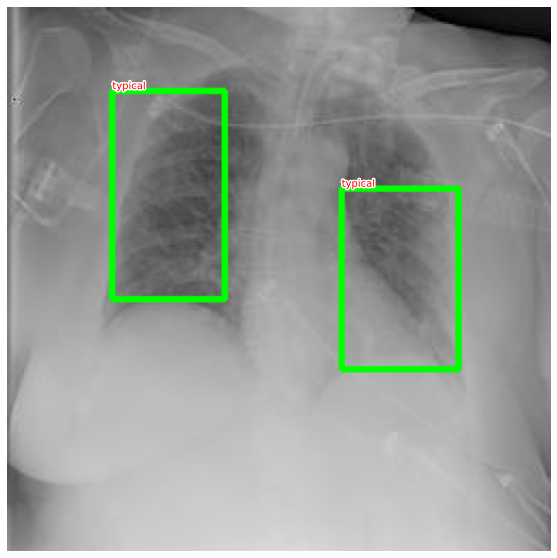

'\n(XMin,Ymin)-> 이미지 좌측 하단 좌표의 정규화 값\n(XMax,Ymax)-> 이미지 우측 상단 좌표의 정규화 값\n네 값으로 bb 생성\n'

In [14]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder=image_root):
        self.root = image_folder
        self.df = df 
        self.unique_images = df['id'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix] #파일 고유명
        image_path = f'{self.root}/{image_id}.jpg' #이미지의 전체경로
        #print(image_id)
        #print(image_path)
        image = cv2.imread(image_path, 1)[...,::-1] # convert BGR to RGB
        #print(len(image))
        h, w, _ = image.shape # h=높이, w= 너비 _=채널(depth)
        #print(h,w,_)
        df = self.df.copy() #이미지 변형방지를 위한 복사
        df = df[df['id'] == image_id] 
        boxes = df['frac_xmin,frac_ymin,frac_xmax,frac_ymax'.split(',')].values #csv 에서 정규화 되어있는 값 가져오기
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist() #정규화된 값 -> 정수->리스트 담기
        classes = df['human_label'].values.tolist() #분류된 box의 라벨명->리스트
        #print(classes) 
        return image, boxes, classes, image_path
ds = OpenImages(df=data)
im, bbs, clss, _ = ds[4] #image(RGB), boxes(여러개), lablename, path
#print(im)
#print(type(bbs))
#print(ds[2])
show(im, bbs=bbs, texts=clss, sz=10)

"""
(XMin,Ymin)-> 이미지 좌측 하단 좌표의 정규화 값
(XMax,Ymax)-> 이미지 우측 상단 좌표의 정규화 값
네 값으로 bb 생성
"""

### 4. Region Proposal

In [15]:
import time
a = time.time()
print(a)

1658934896.6111157


In [16]:
def extract_candidates(img): 
    img_lbl, regions = selectivesearch.selective_search(img ,scale=256, min_size=20)
    img_area = np.prod(img.shape[:2])#np.prod ->요소들의 곱 반환
    #print(img_area)
    #print(img.shape[:2]) -> W,H -> W*H
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue # 너무 작은 값 pass
        if r['size'] > (1*img_area): continue #너무 큰 값 pass
        x, y, w, h = r['rect']
        #print(x,y,w,h)
        candidates.append(list(r['rect']))
    return candidates

In [17]:
def extract_iou(boxA, boxB, epsilon=1e-5):
    #두 영역의 교집합 구하기
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height #교집합 넓이
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1]) #a의 넓이
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1]) #b의 넓이
    area_combined = area_a + area_b - area_overlap #합집합 넓이
    iou = area_overlap / (area_combined+epsilon) # 교집합/합집합 ->비율
    return iou

In [53]:
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
#N = 1
#N = 300
a = 0
for ix, (im, bbs, labels, fpath) in enumerate(ds): 
#     if(ix==N):
#         break
    H, W, _ = im.shape #이미지의 높이,너비,채널
    candidates = extract_candidates(im)  
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])#x,y ->bb의 좌상단 좌표
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : pass
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H]) 
        #print(len(delta))#정규화
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))

    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{image_root}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [55]:
print(len(FPATHS))
print(len(GTBBS))
print(len(CLSS))
print(len(DELTAS))
print(len(ROIS))

500
500
500
500
500


In [58]:
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
#background_class = label2target['background']


print("The label to target values dictionary formed is:" ,label2target)

The label to target values dictionary formed is: {'typical': 0, 'atypical': 1, 'indeterminate': 2}


In [59]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
# normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                                  std=[0.5, 0.5, 0.5])
def preprocess_image(img):
    #RGB to BGR
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds

### 4. Fast R-CNN

In [60]:
class FRCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1] # convert BGR to RGB
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, {len(labels)}, {len(deltas)}'
        return image, rois, labels, deltas, gtbbs, fpath

    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas

In [61]:
# Data의 90% ->Train 나머지 Test
n_train = 9*len(FPATHS)//10
print(n_train)
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

450


In [62]:
for input, rois, rixs, labels, deltas in train_loader:
    print(input.shape)
    print(labels) # labels 값이 각 batch_size마다 다름
    

AssertionError: 38, 2, 38

In [28]:
from torchvision.ops import RoIPool
class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        rawnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights)#backbone
        for param in rawnet.parameters():
            param.requires_grad = True
        self.seq = nn.Sequential(*list(rawnet.children())[:-1])
        self.roipool = RoIPool(7, spatial_scale=14/224)
        feature_dim = 2048*7*7 #512->2048로 변경
        self.cls_score = nn.Sequential(
            nn.Linear(feature_dim,2048),
            nn.ReLU(),
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Linear(1024,len(label2target)))
        self.bbox = nn.Sequential(
            nn.Linear(feature_dim, 2048),
            nn.ReLU(),
            #nn.Linear(2048,1024),
            #nn.ReLU(),
#             nn.Linear(1024,512),
#             nn.ReLU(),
            nn.Linear(2048, 4),
            nn.Tanh(),
            )
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()
    def forward(self, input, rois, ridx):
        res = input
        res = self.seq(res)
        rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
        res = self.roipool(res, rois)
        feat = res.view(len(res), -1)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat) # .view(-1, len(label2target), 4)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [29]:
frcnn = FRCNN().to(device)
print(frcnn)

/home/user303/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FRCNN(
  (seq): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, k

### 5.Train

In [30]:
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [31]:
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

### Optimizer

In [32]:
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

n_epochs = 50

In [33]:
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')
        
    log.report_avgs(epoch+1)

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

EPOCH: 1.000	trn_loss: 1.679	trn_loc_loss: 1.254	trn_regr_loss: 0.043	trn_acc: 0.953	val_loss: 1.406	val_loc_loss: 1.127	val_regr_loss: 0.028	val_acc: 0.981	(8.07s - 395.61s remaining)
EPOCH: 2.000	trn_loss: 1.388	trn_loc_loss: 1.002	trn_regr_loss: 0.039	trn_acc: 0.955	val_loss: 1.179	val_loc_loss: 0.890	val_regr_loss: 0.029	val_acc: 0.980	(14.54s - 348.87s remaining)
EPOCH: 3.000	trn_loss: 1.161	trn_loc_loss: 0.788	trn_regr_loss: 0.037	trn_acc: 0.955	val_loss: 1.028	val_loc_loss: 0.725	val_regr_loss: 0.030	val_acc: 0.980	(21.05s - 329.83s remaining)
EPOCH: 4.000	trn_loss: 1.049	trn_loc_loss: 0.683	trn_regr_loss: 0.037	trn_acc: 0.955	val_loss: 0.952	val_loc_loss: 0.645	val_regr_loss: 0.031	val_acc: 0.980	(27.54s - 316.73s remaining)
EPOCH: 5.000	trn_loss: 0.999	trn_loc_loss: 0.633	trn_regr_loss: 0.037	trn_acc: 0.955	val_loss: 0.907	val_loc_loss: 0.600	val_regr_loss: 0.031	val_acc: 0.980	(34.01s - 306.07s remaining)
EPOCH: 6.000	trn_loss: 0.959	trn_loc_loss: 0.601	trn_regr_loss: 0.036	t

KeyboardInterrupt: 

In [34]:
import time
b = time.time()
print(b)

1658935737.5979111


In [36]:
b-a

1658935737.5979111

### 6. Test

In [ ]:
#image = cv2.imread(image_path, 1)[...,::-1]

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image
def test_predictions(filename):
    img = cv2.resize(cv2.imread(filename, 1)[...,::-1], (224,224))
    print(img.shape)
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = preprocess_image(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois))
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval() ##eval() -> gradient 고정
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    
    print(clss)
    print(background_class)
    ixs = clss!=background_class
    print(ixs)
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    print(bbs)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.00000000001)
    print(ixs)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    
    bbs = bbs.astype(np.uint16)
    print(bbs)
    _, ax = plt.subplots(1, 2, figsize=(20,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

(224, 224, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
[]
tensor([], dtype=torch.int64)
[]


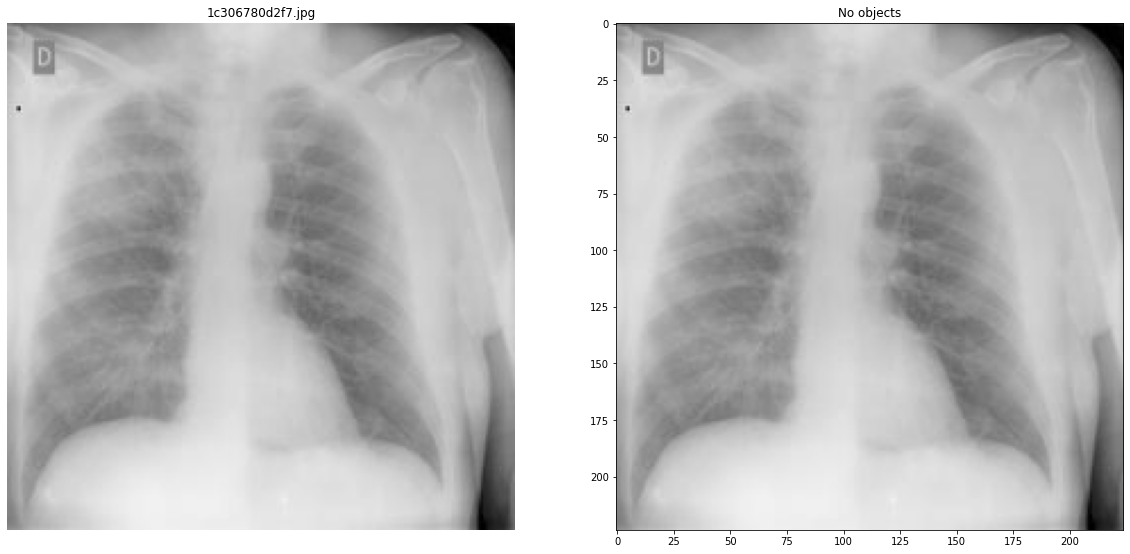

In [52]:
test_predictions(test_ds[47][-1])

(224, 224, 3)


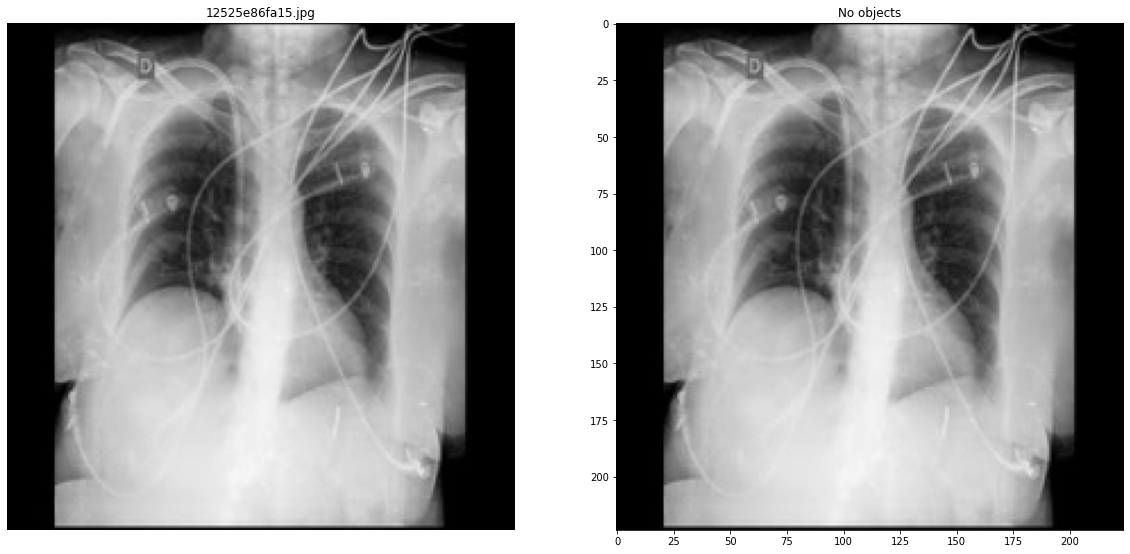

(224, 224, 3)


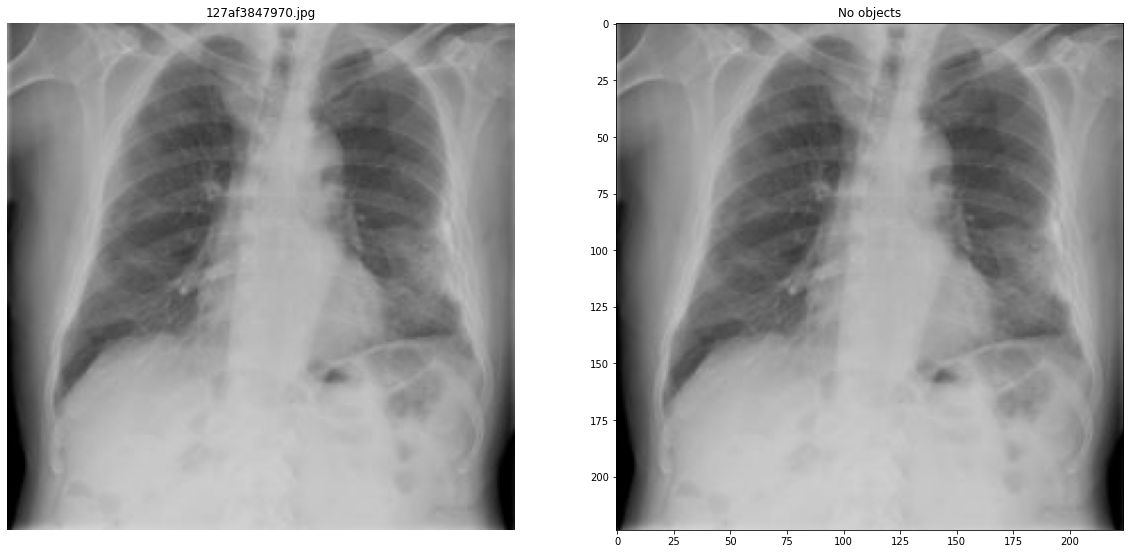

(224, 224, 3)


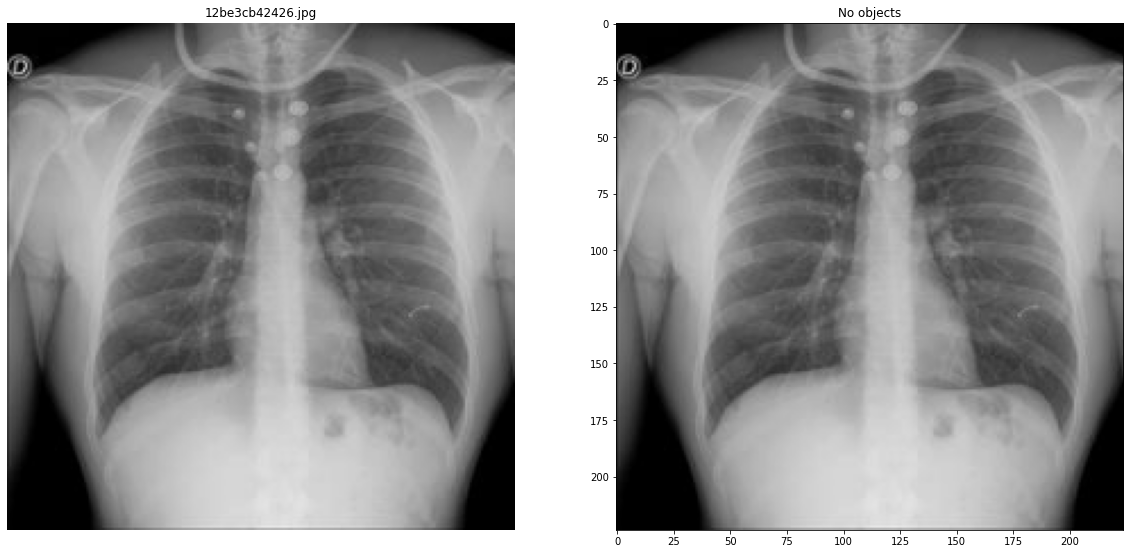

(224, 224, 3)


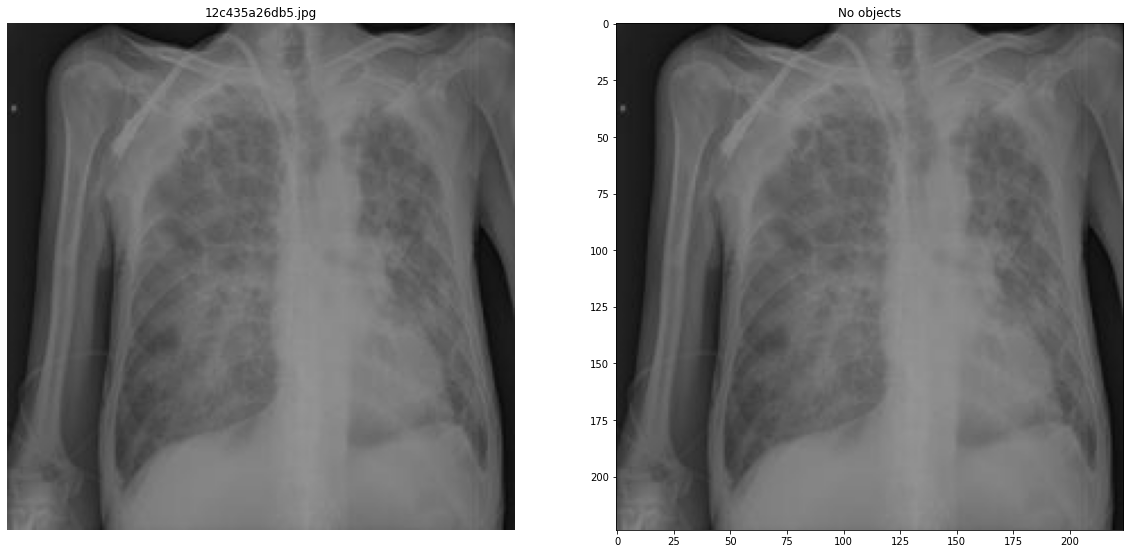

(224, 224, 3)


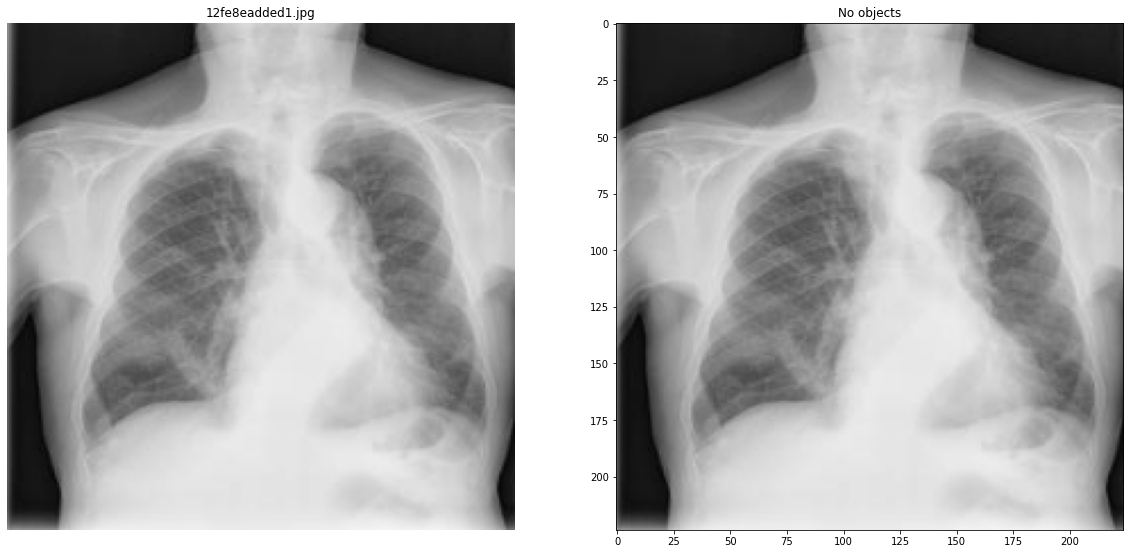

(224, 224, 3)


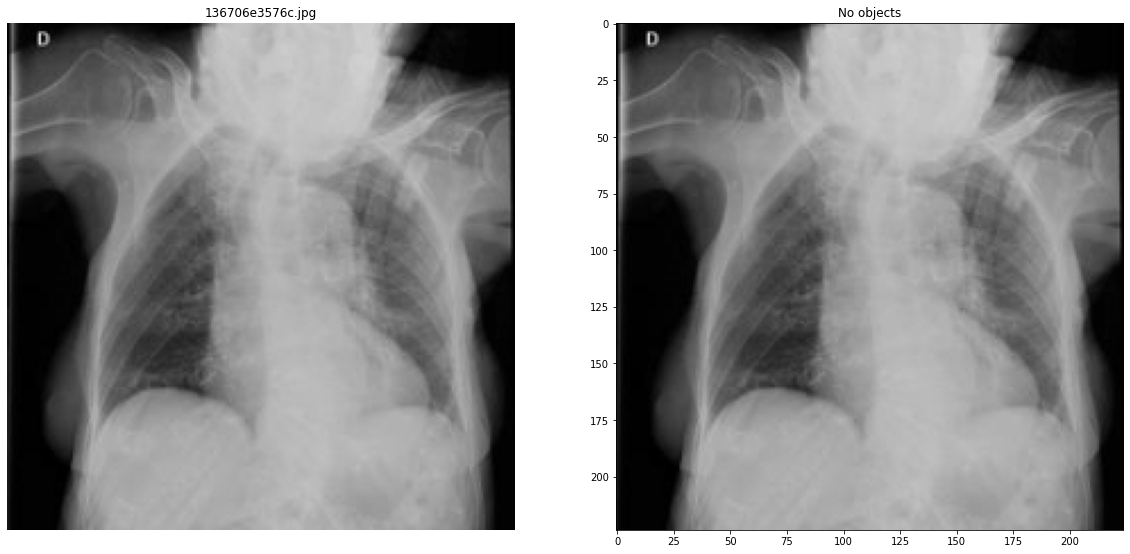

(224, 224, 3)


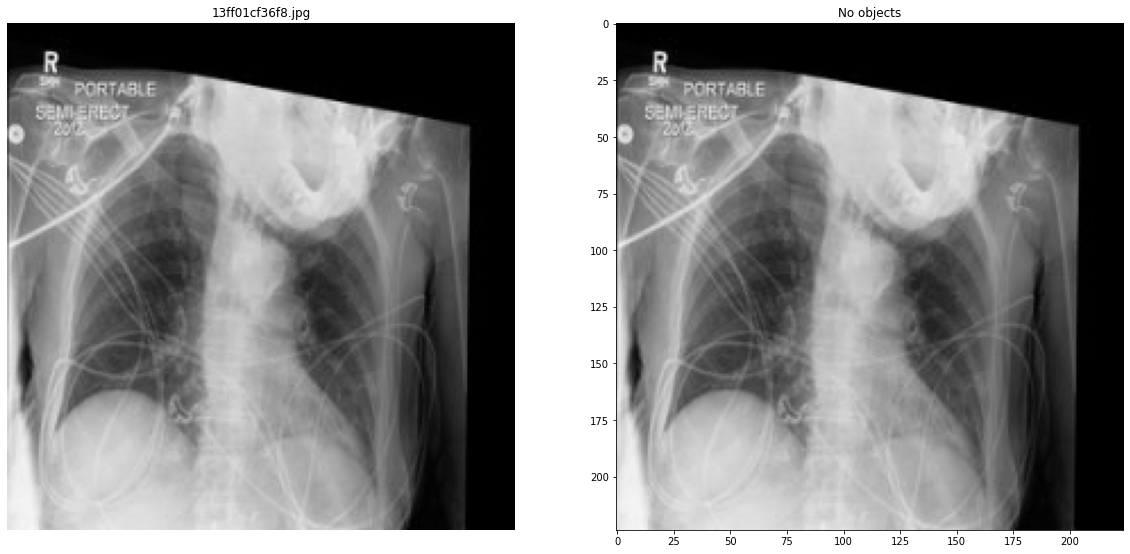

(224, 224, 3)


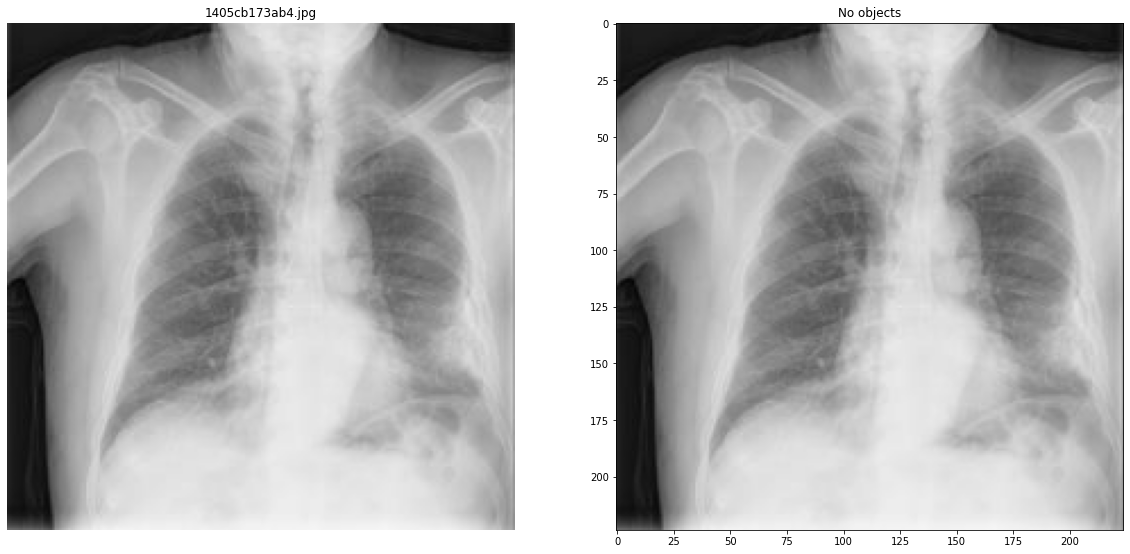

(224, 224, 3)


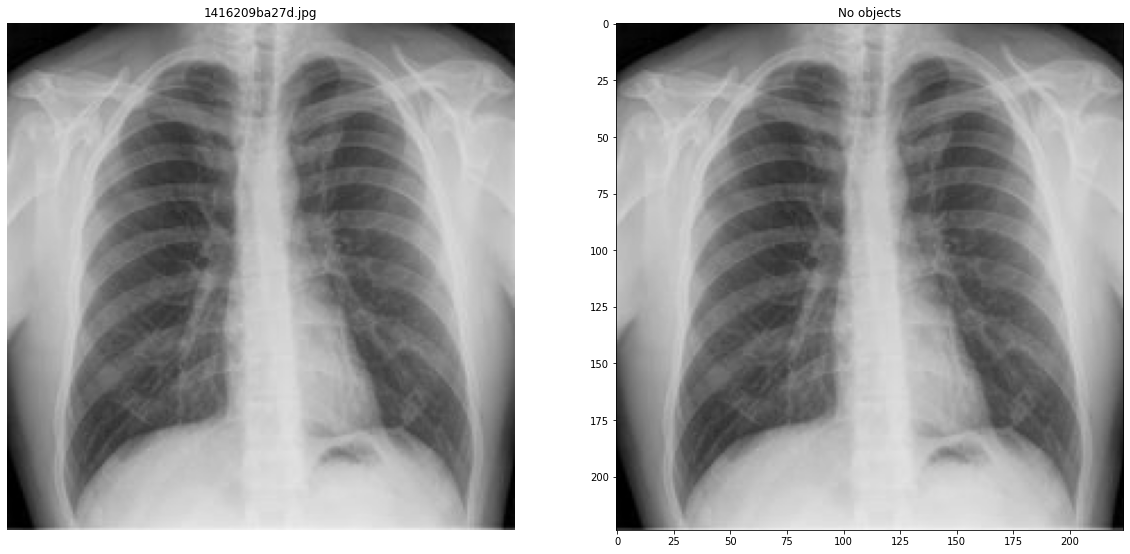

(224, 224, 3)


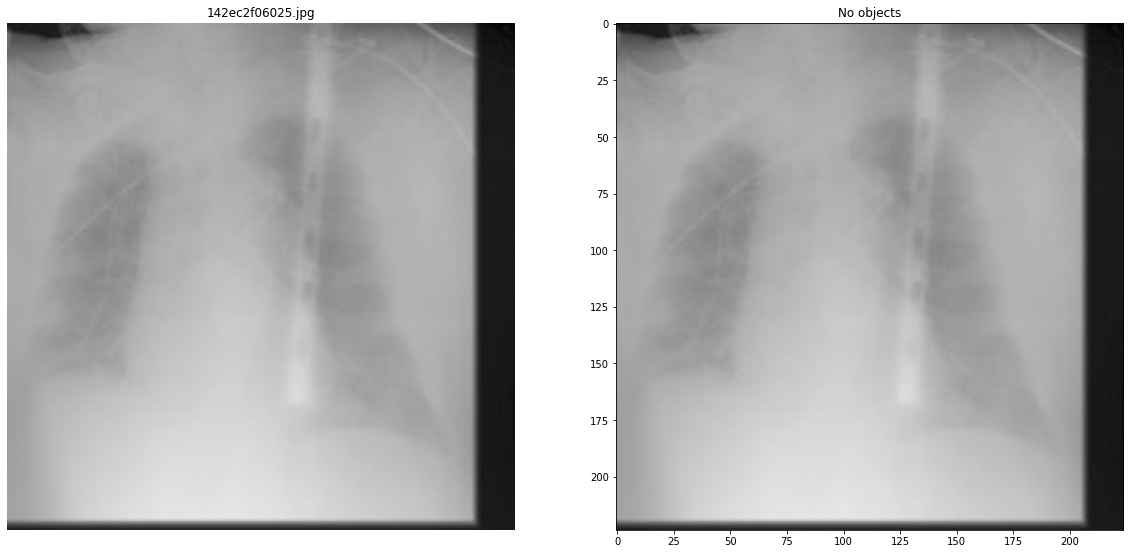

(224, 224, 3)


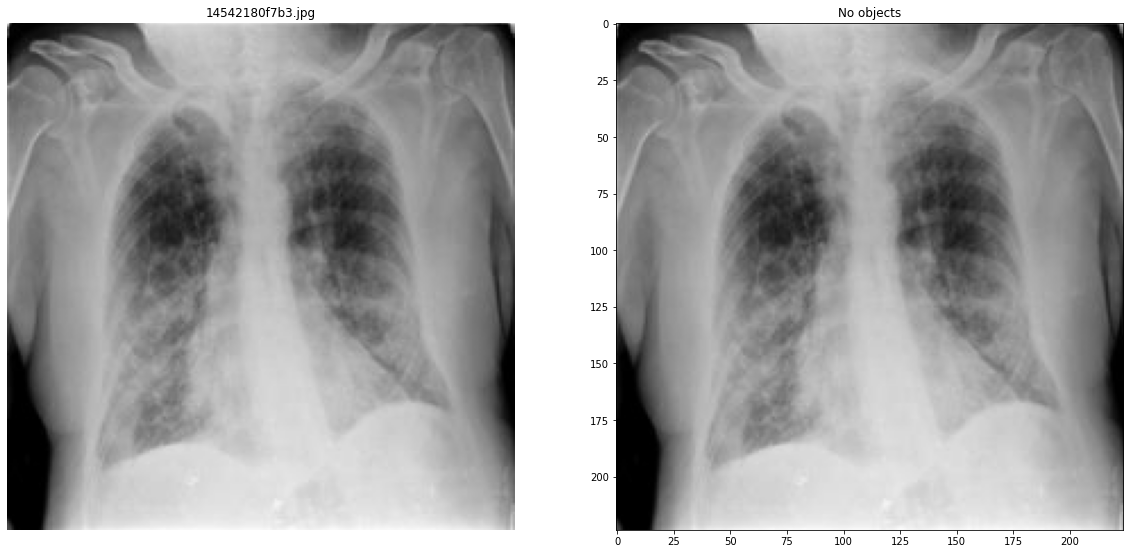

(224, 224, 3)


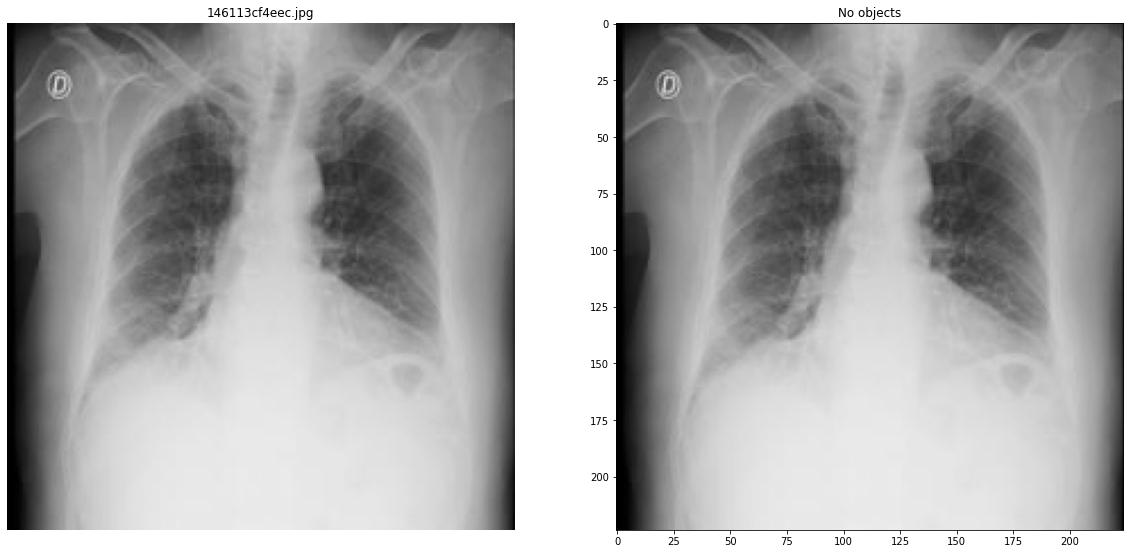

(224, 224, 3)


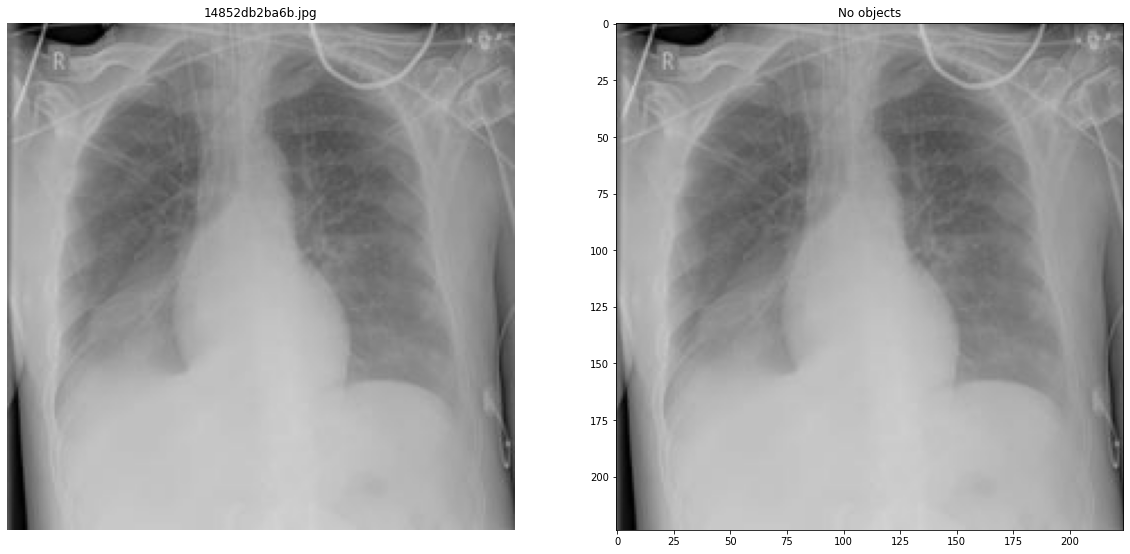

(224, 224, 3)


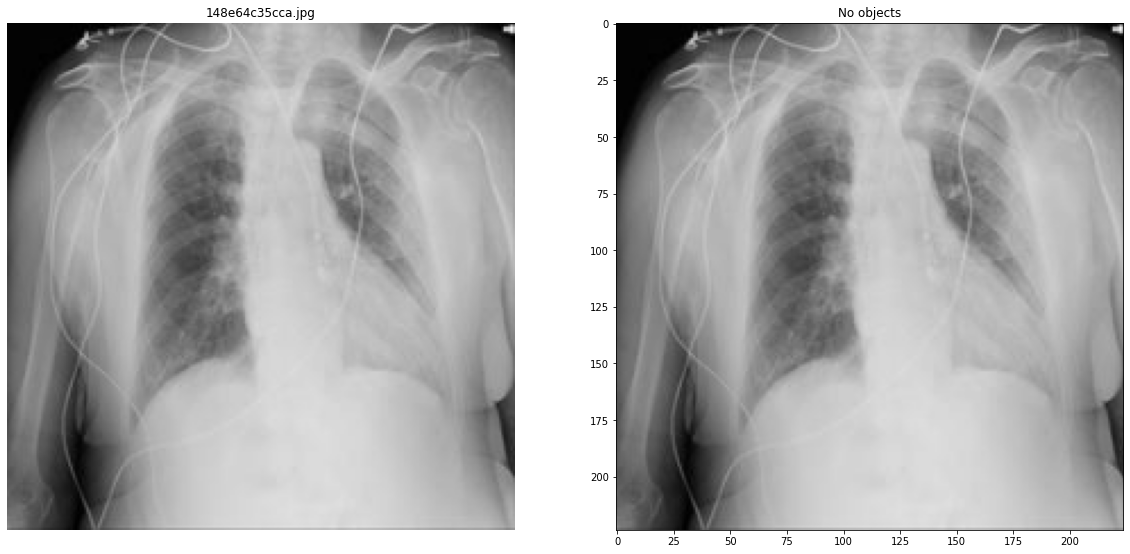

(224, 224, 3)


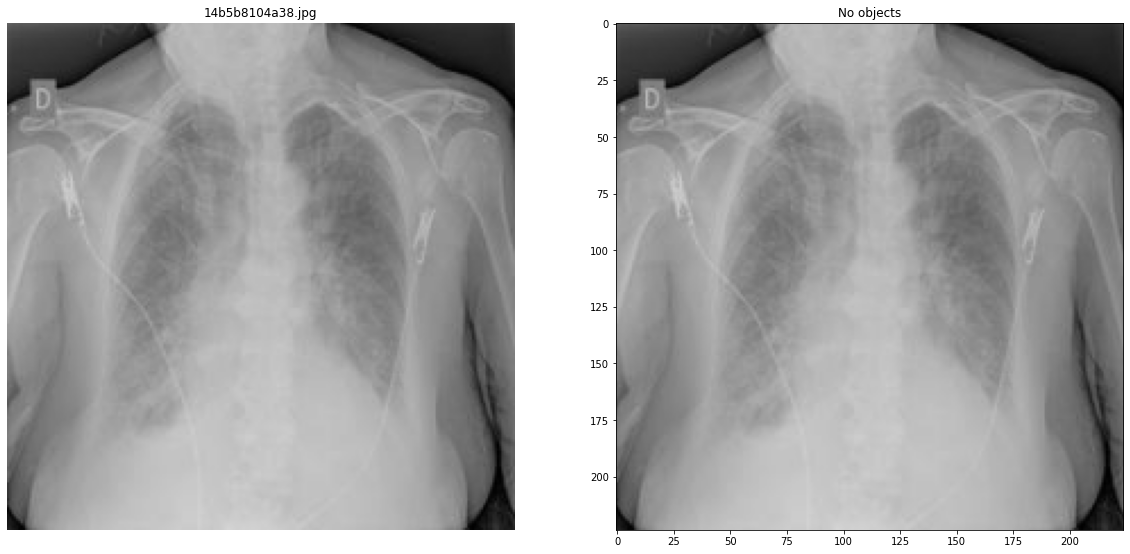

(224, 224, 3)


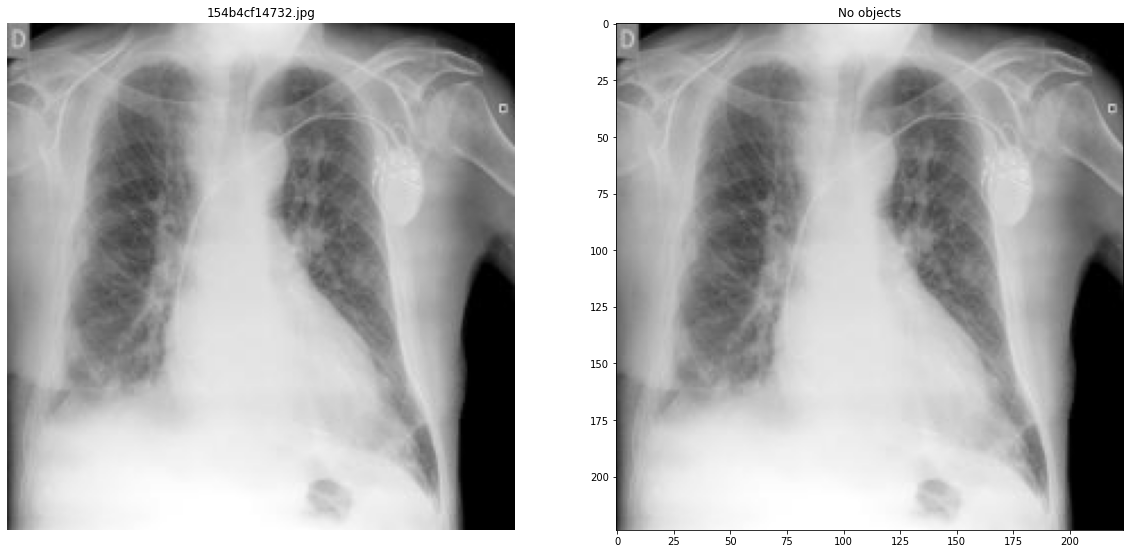

(224, 224, 3)


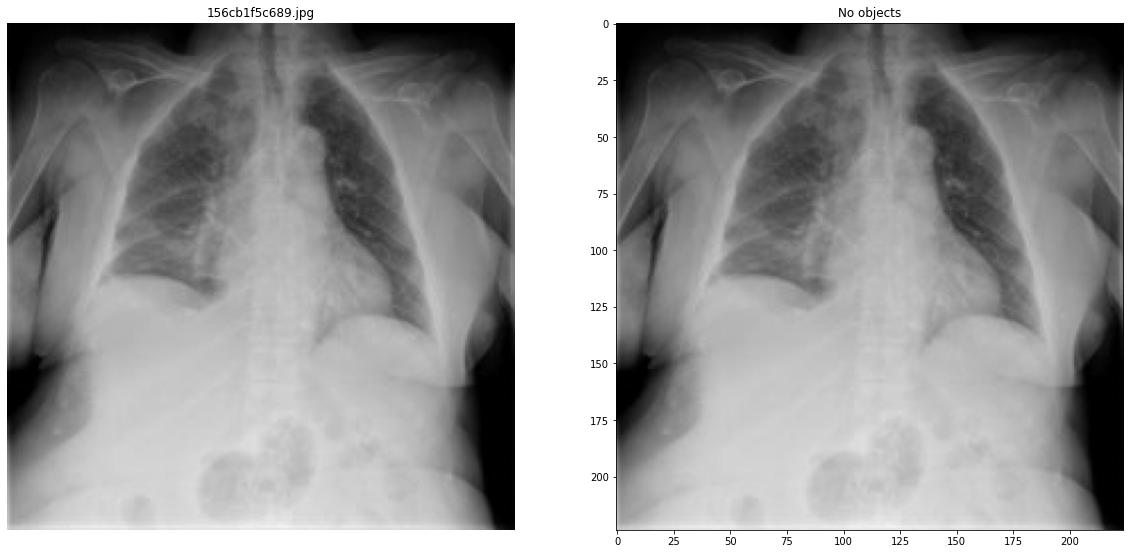

(224, 224, 3)


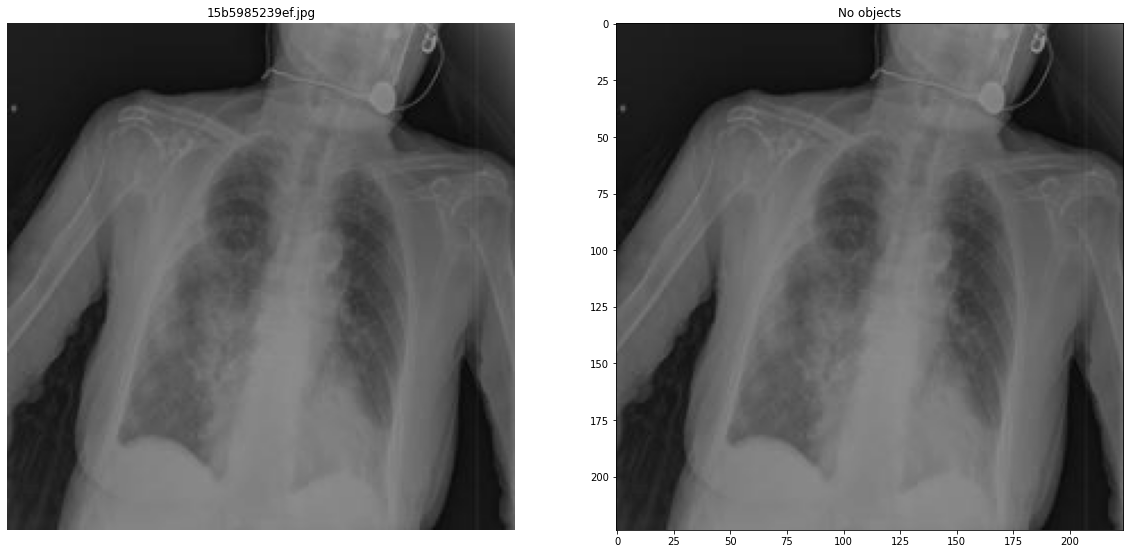

(224, 224, 3)


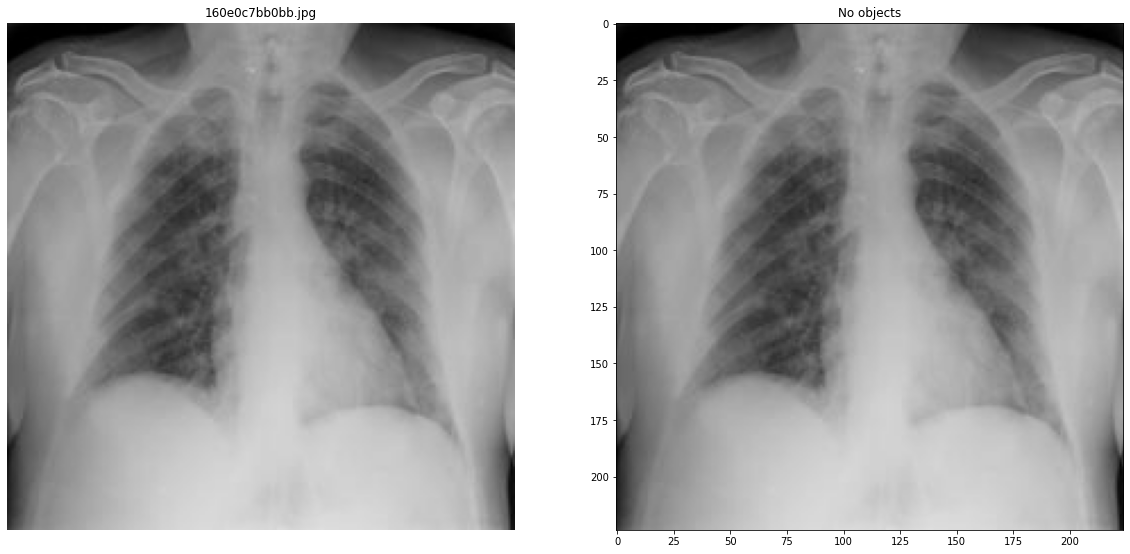

(224, 224, 3)


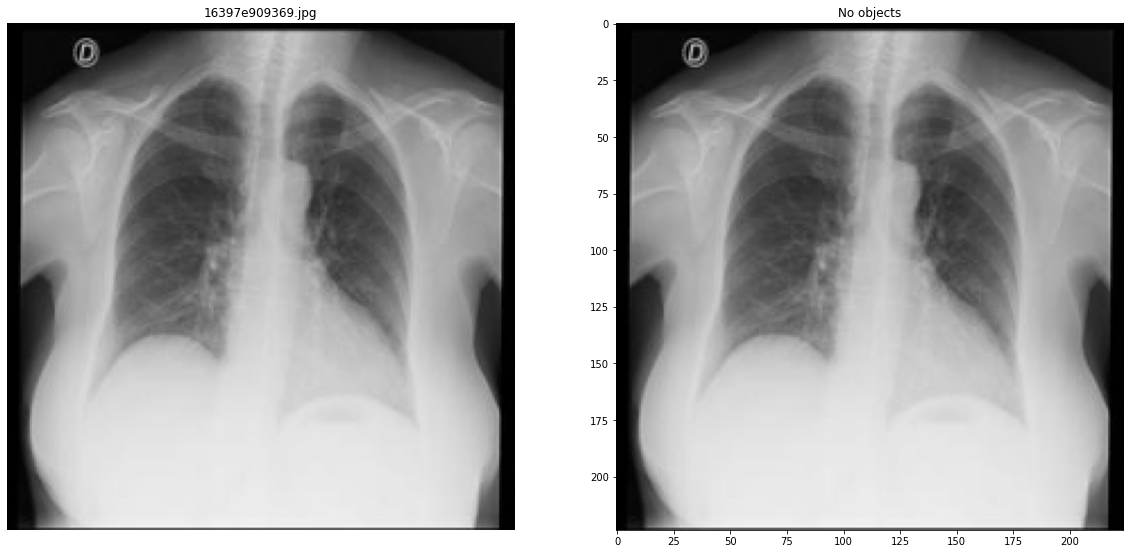

(224, 224, 3)


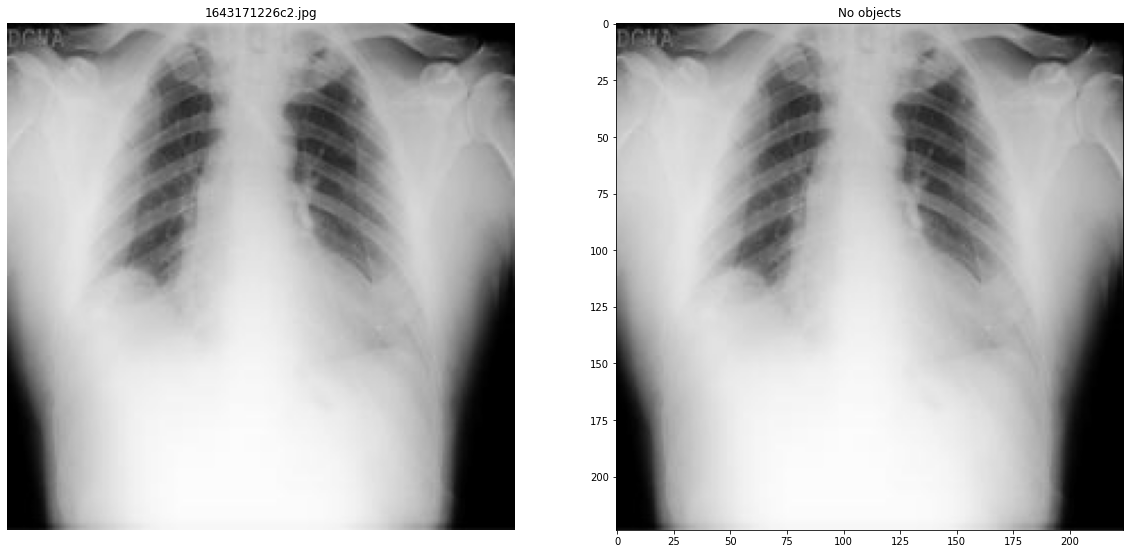

(224, 224, 3)


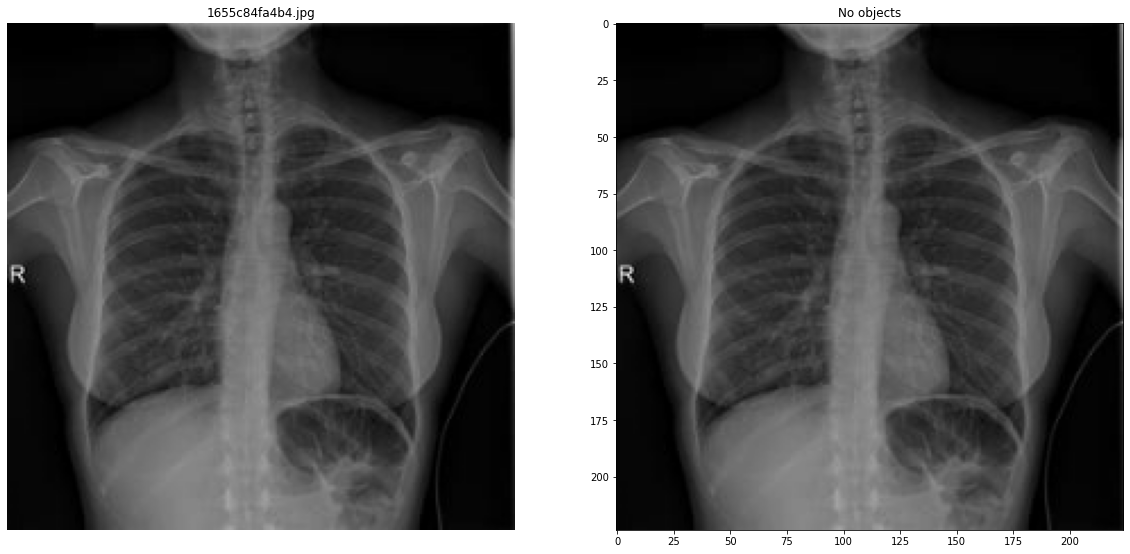

(224, 224, 3)


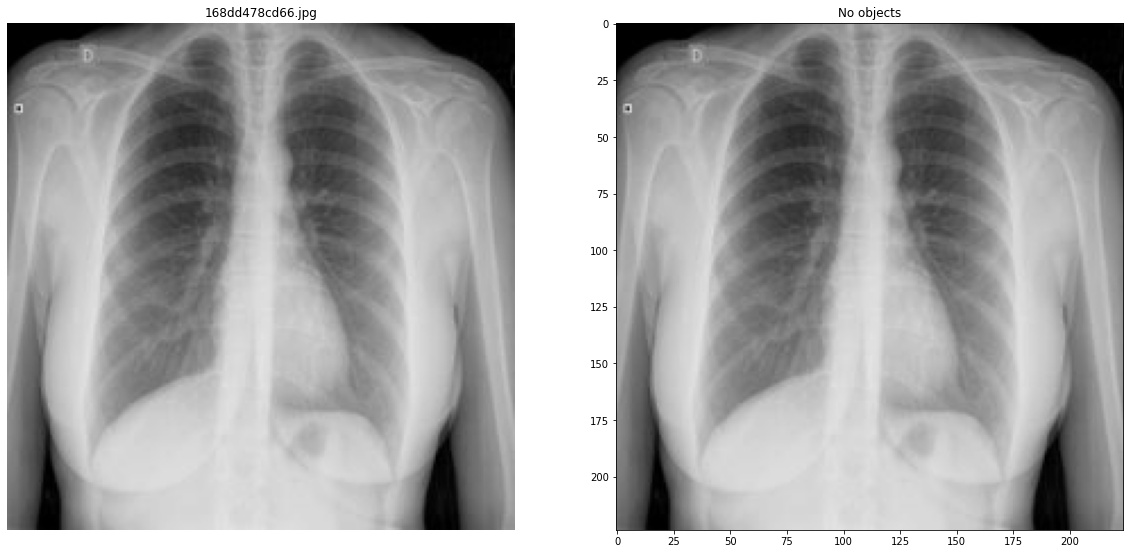

(224, 224, 3)


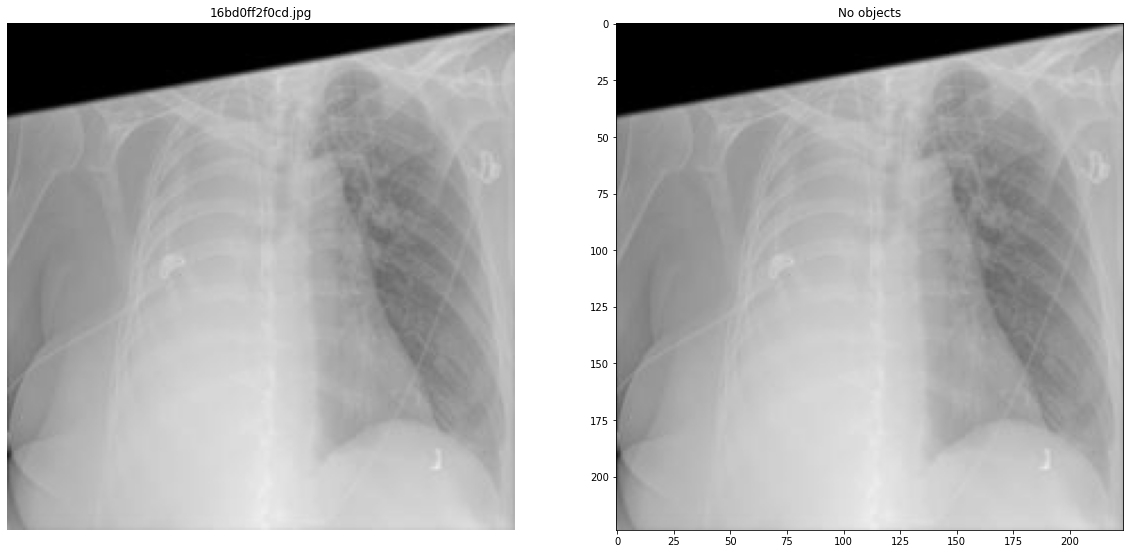

(224, 224, 3)


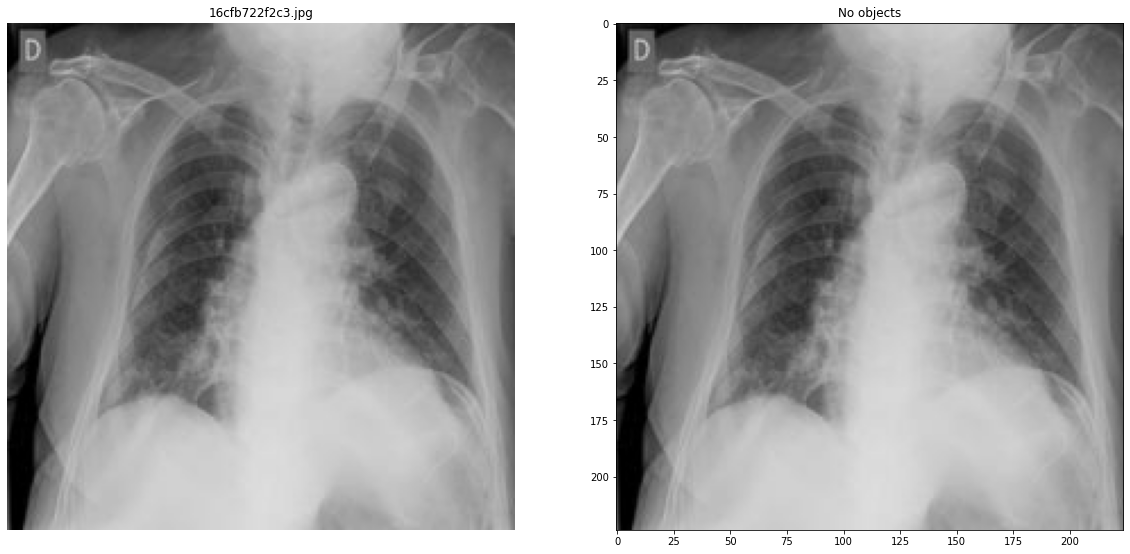

(224, 224, 3)


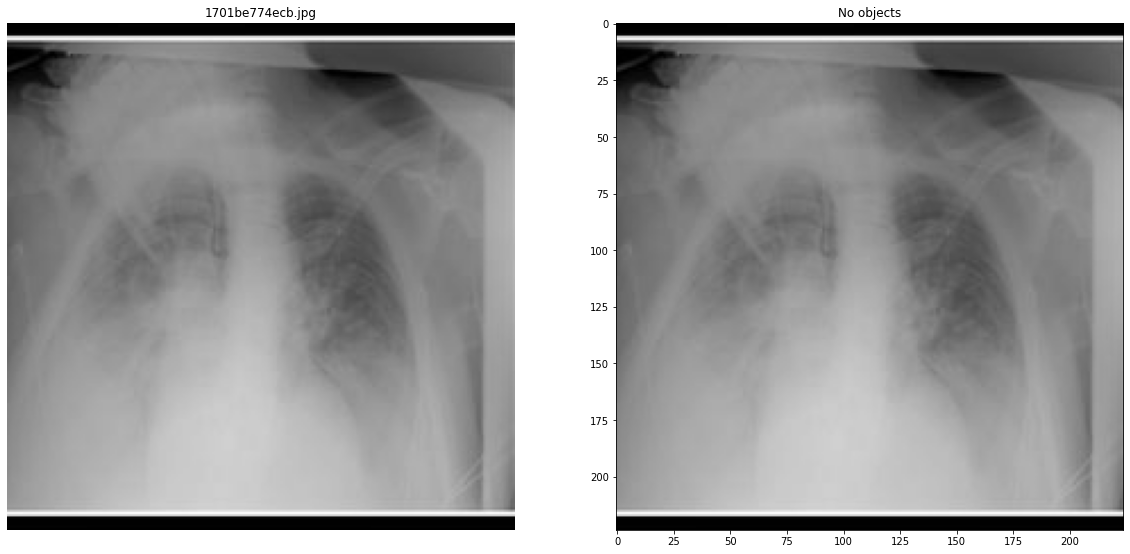

(224, 224, 3)


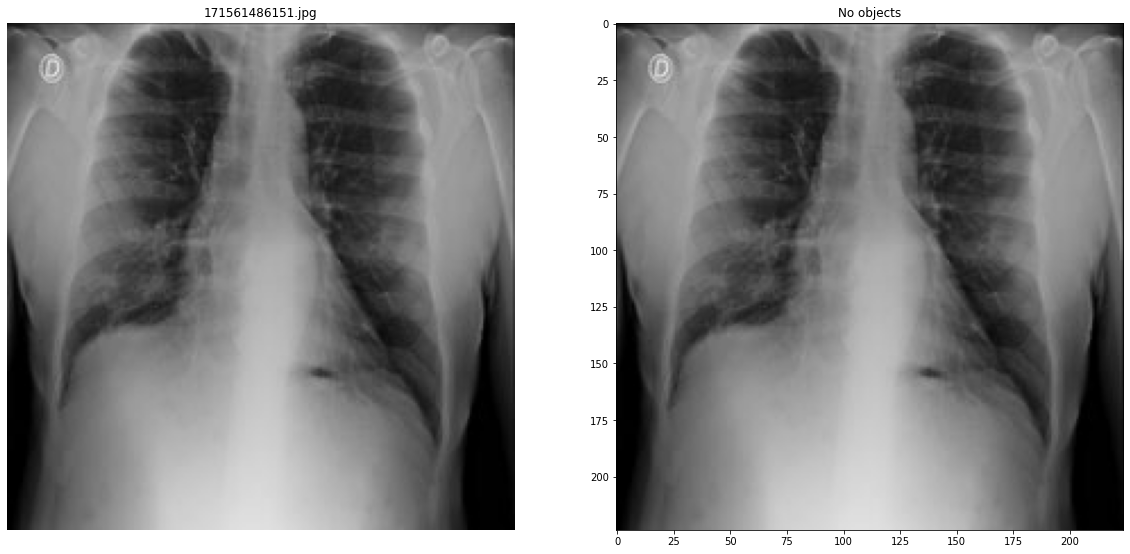

(224, 224, 3)


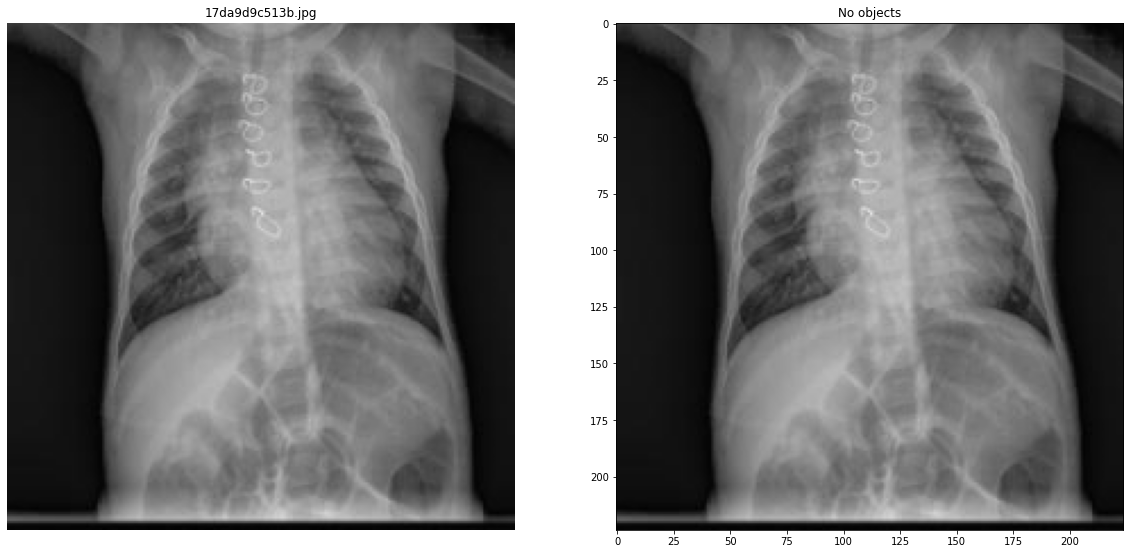

(224, 224, 3)


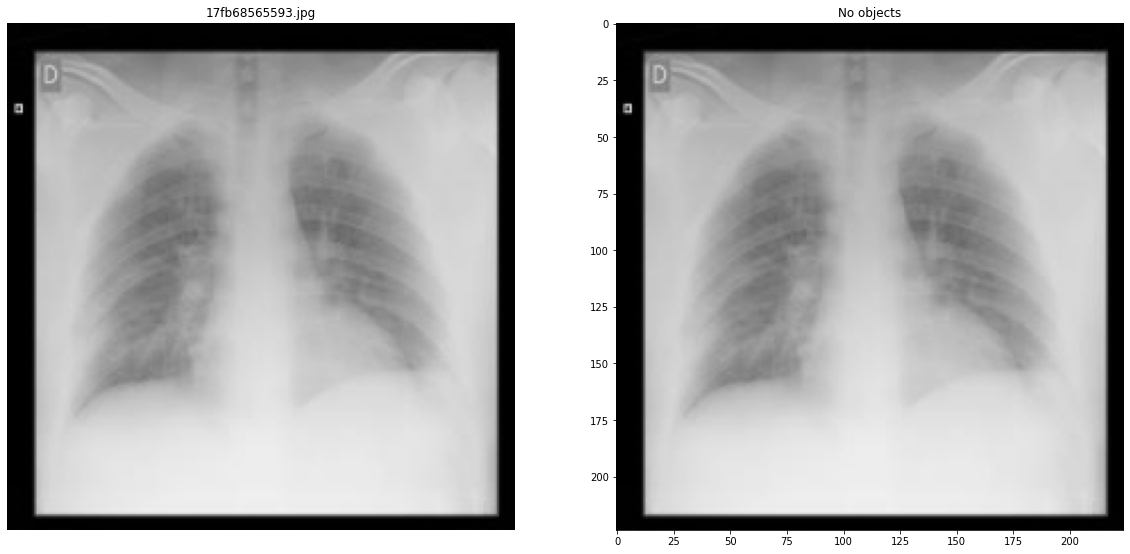

(224, 224, 3)


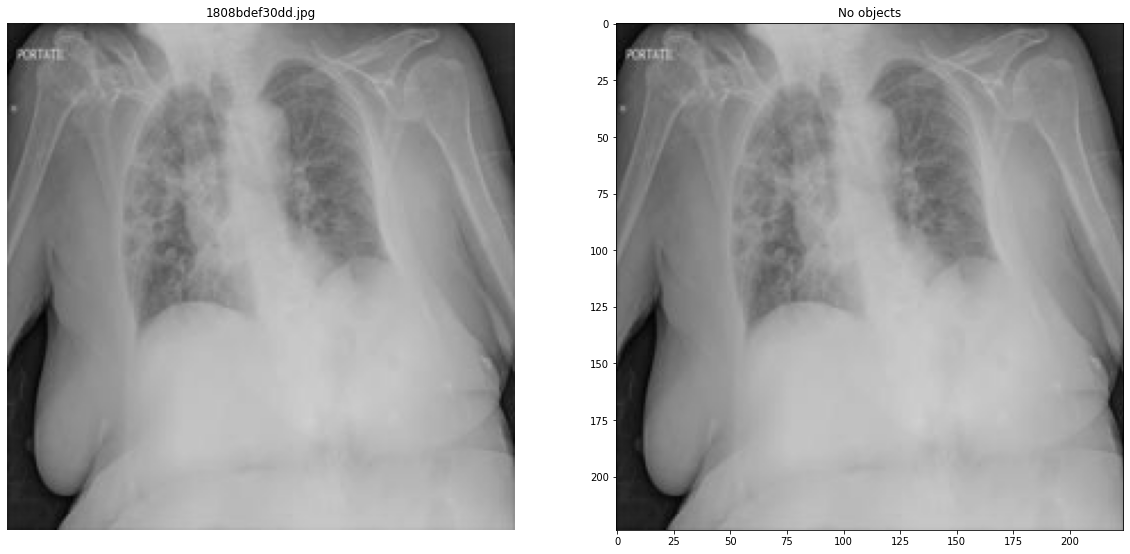

(224, 224, 3)


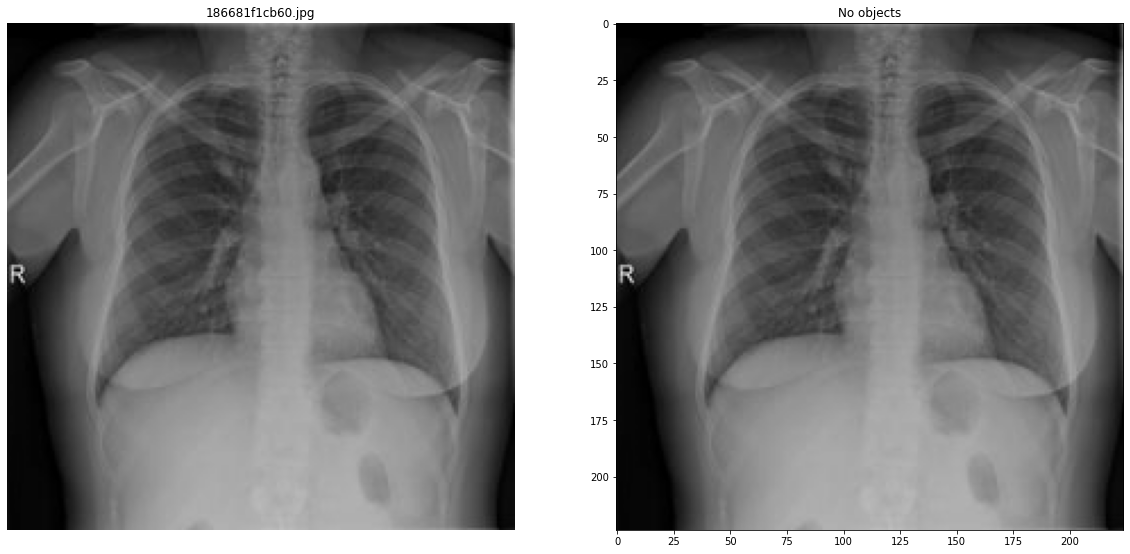

(224, 224, 3)


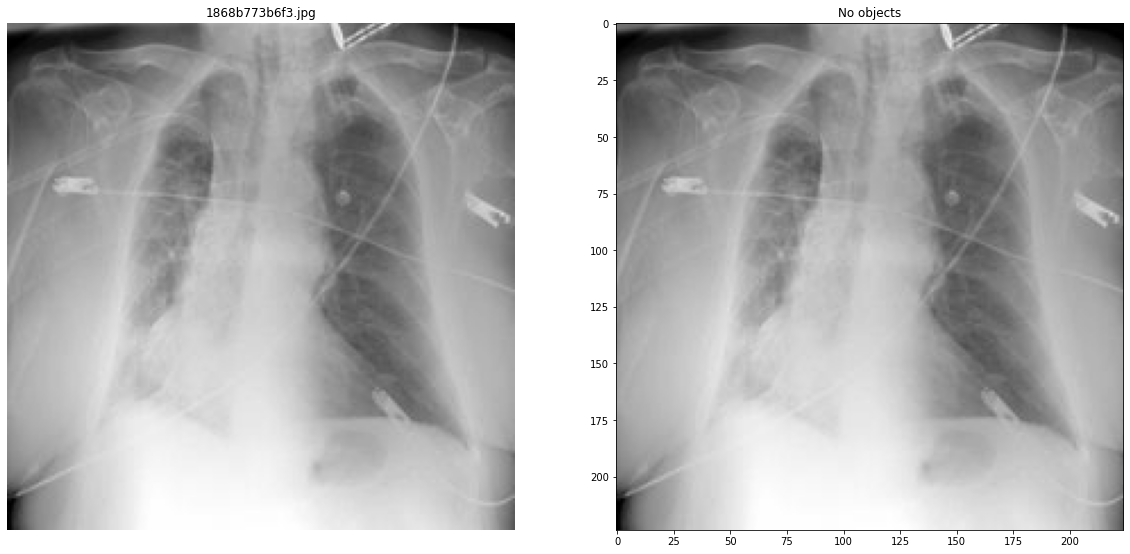

(224, 224, 3)


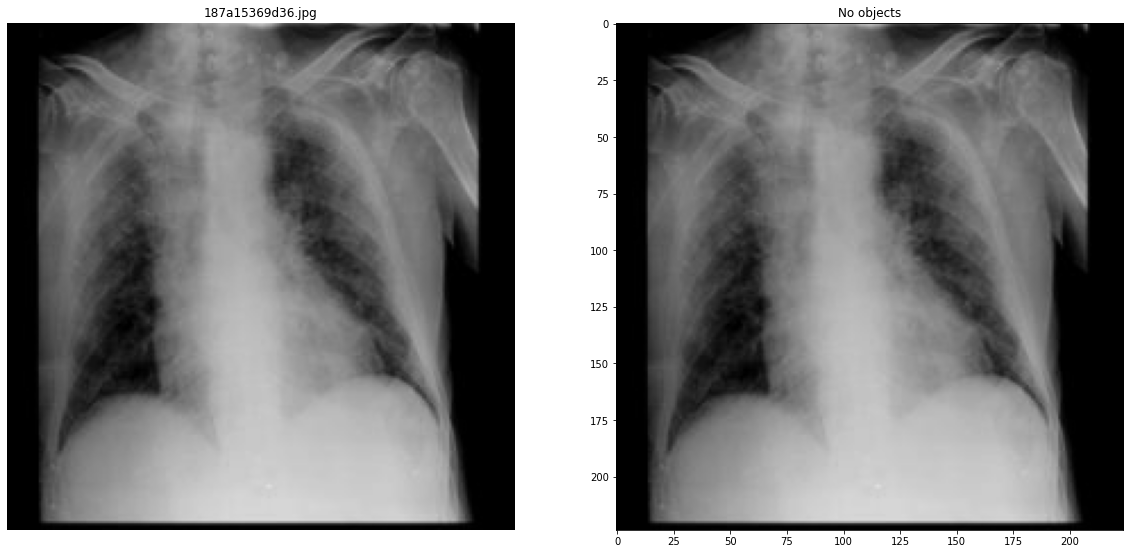

(224, 224, 3)


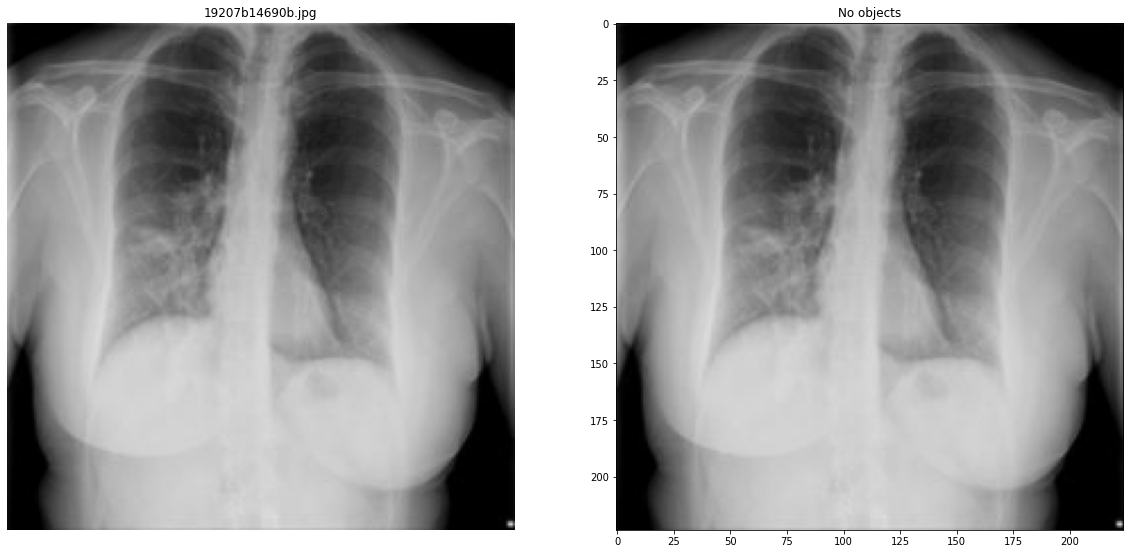

(224, 224, 3)


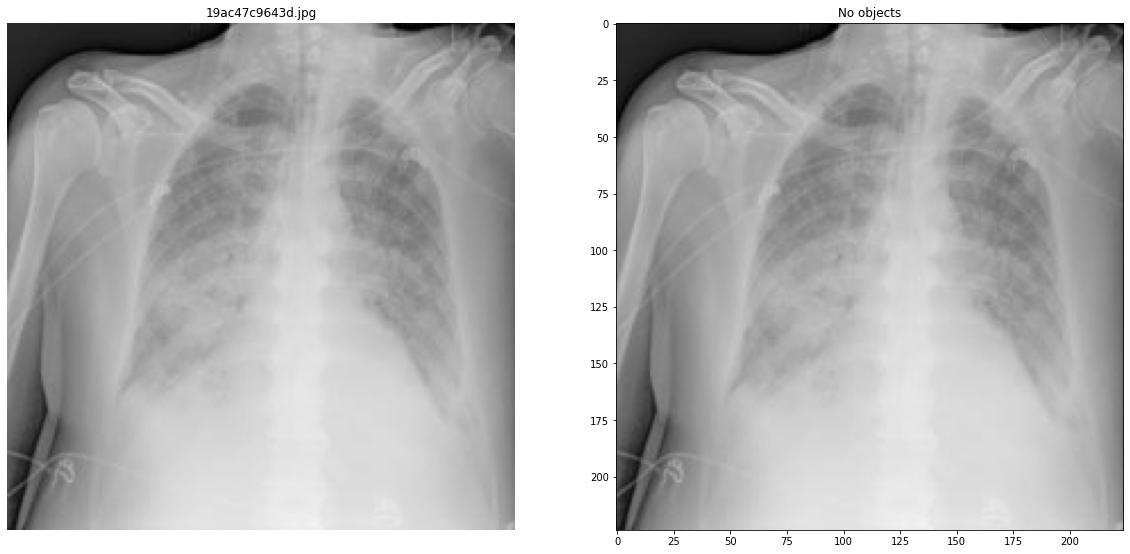

(224, 224, 3)


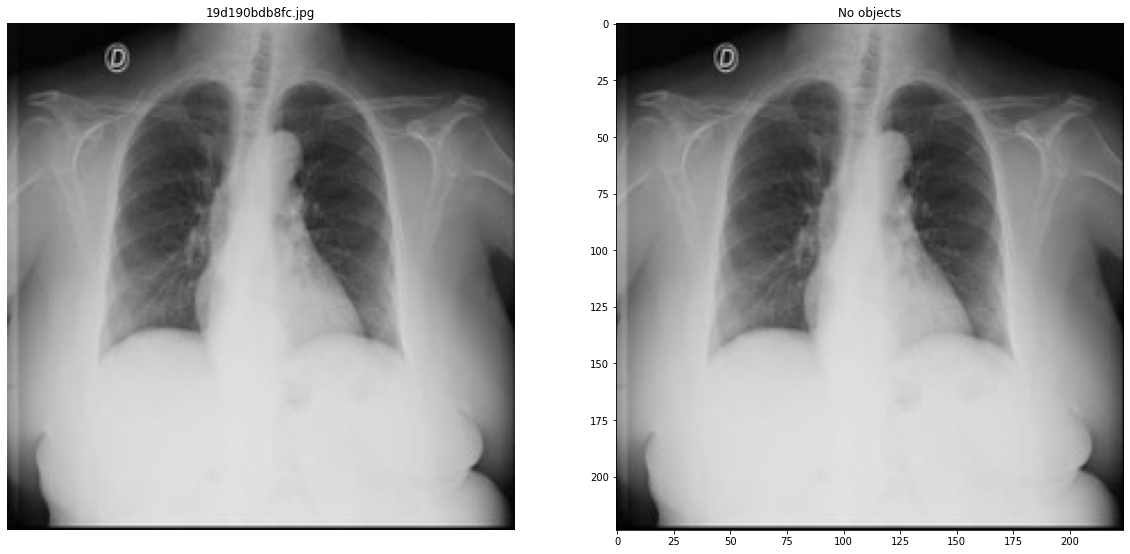

(224, 224, 3)


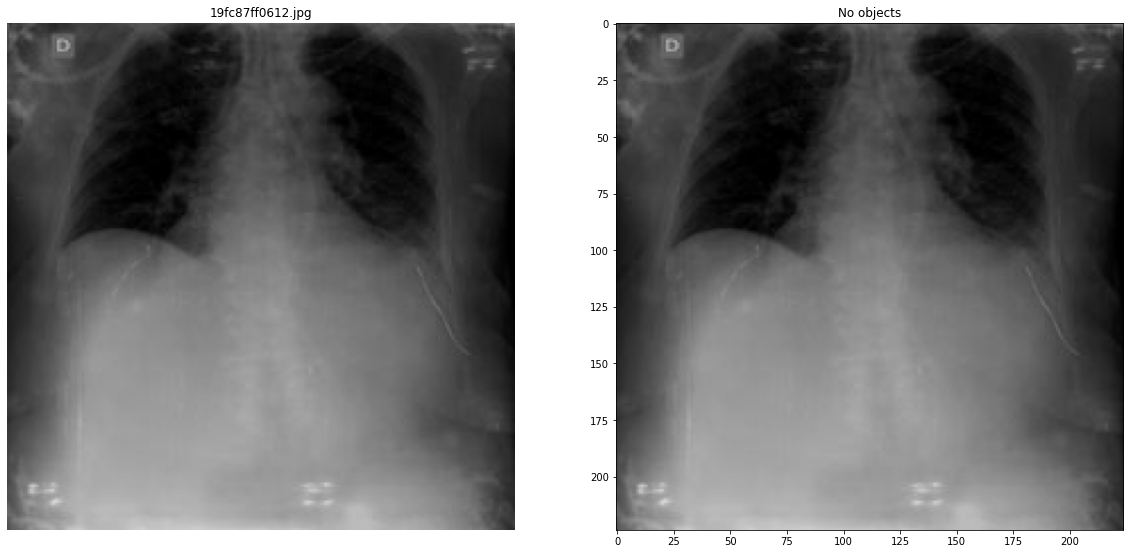

(224, 224, 3)


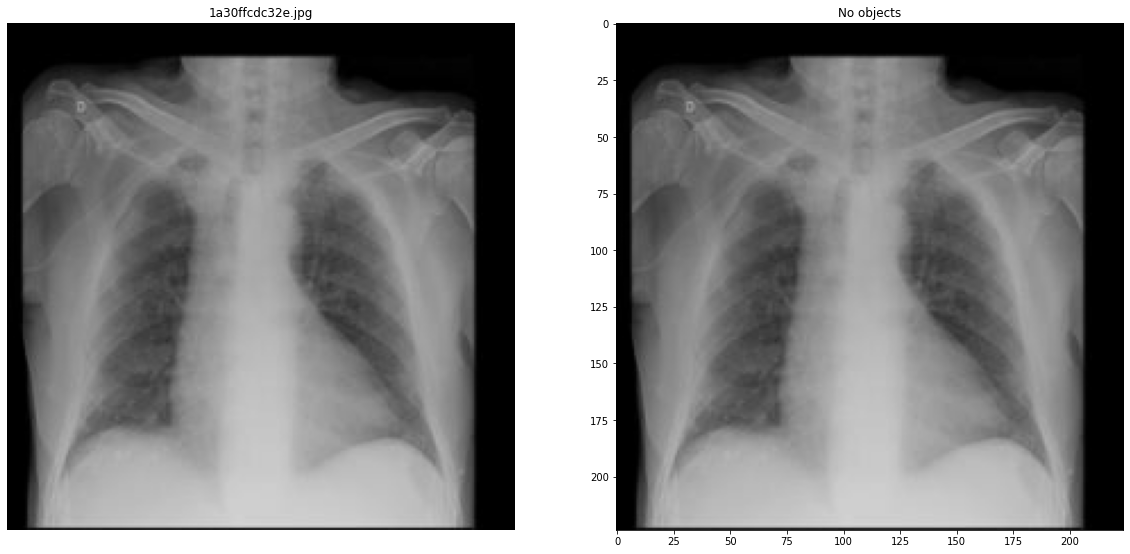

(224, 224, 3)


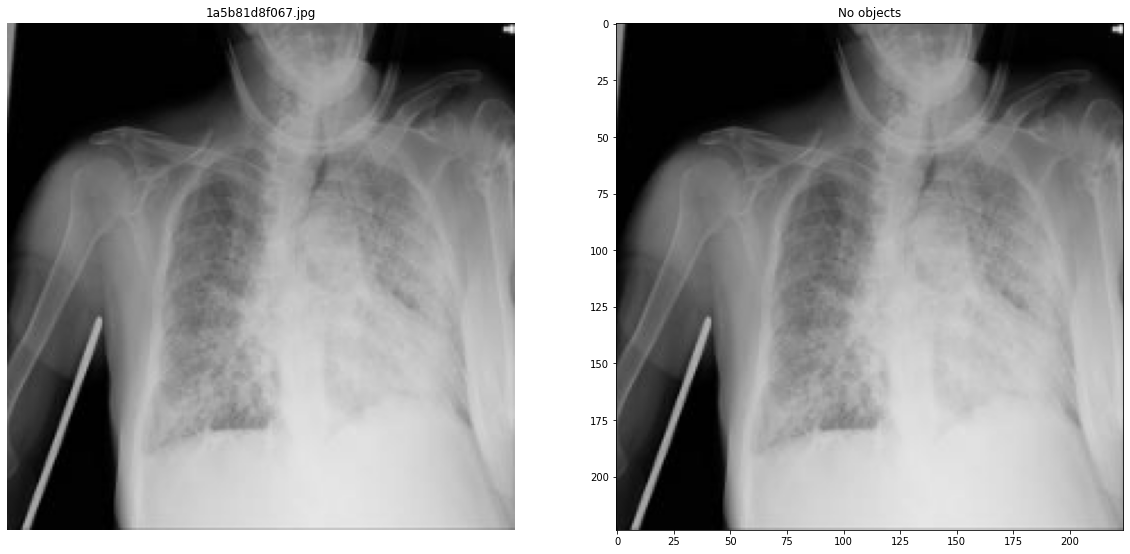

(224, 224, 3)


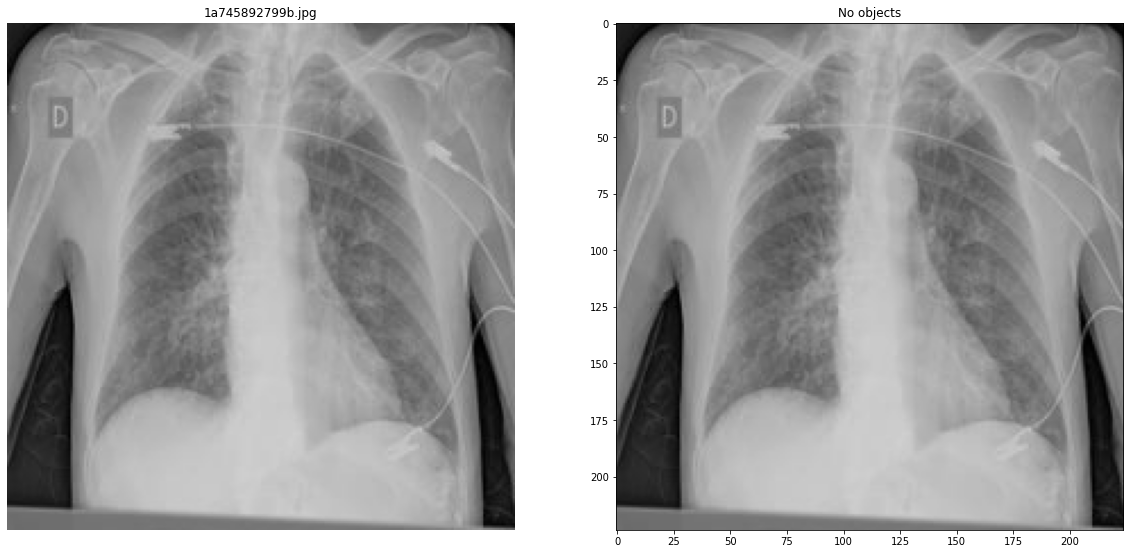

(224, 224, 3)


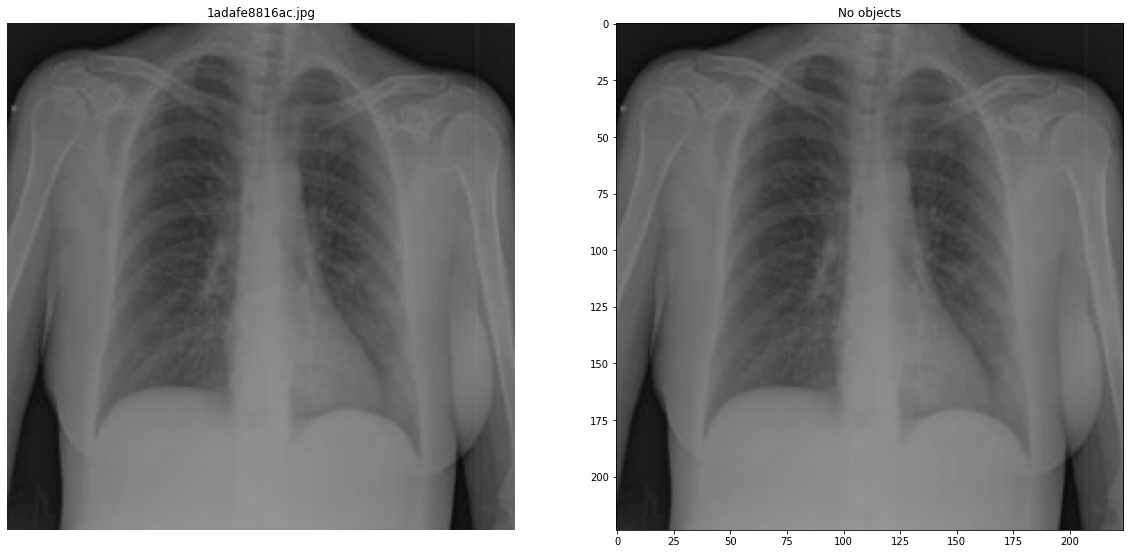

(224, 224, 3)


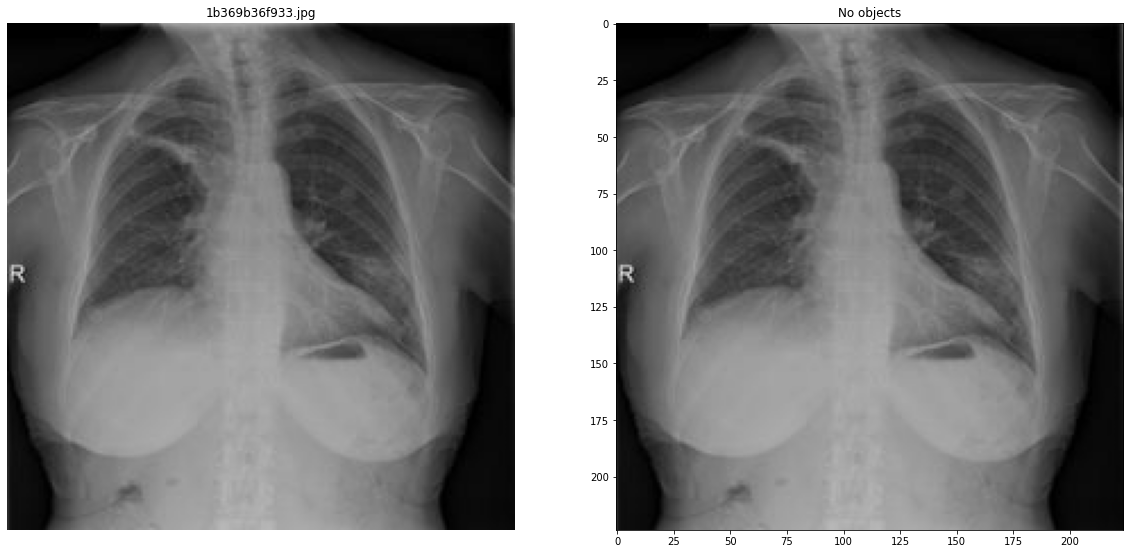

(224, 224, 3)


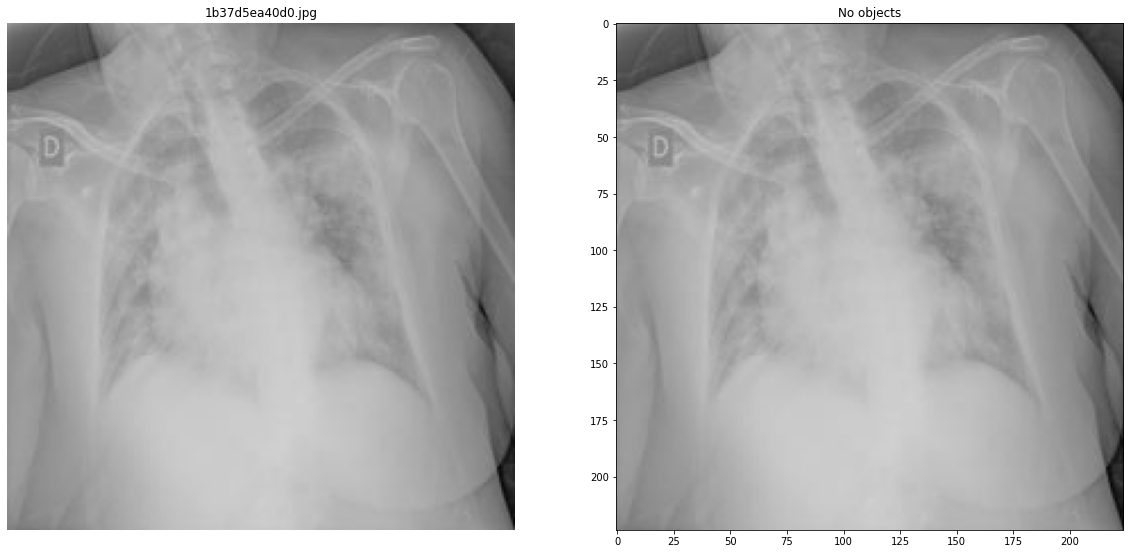

(224, 224, 3)


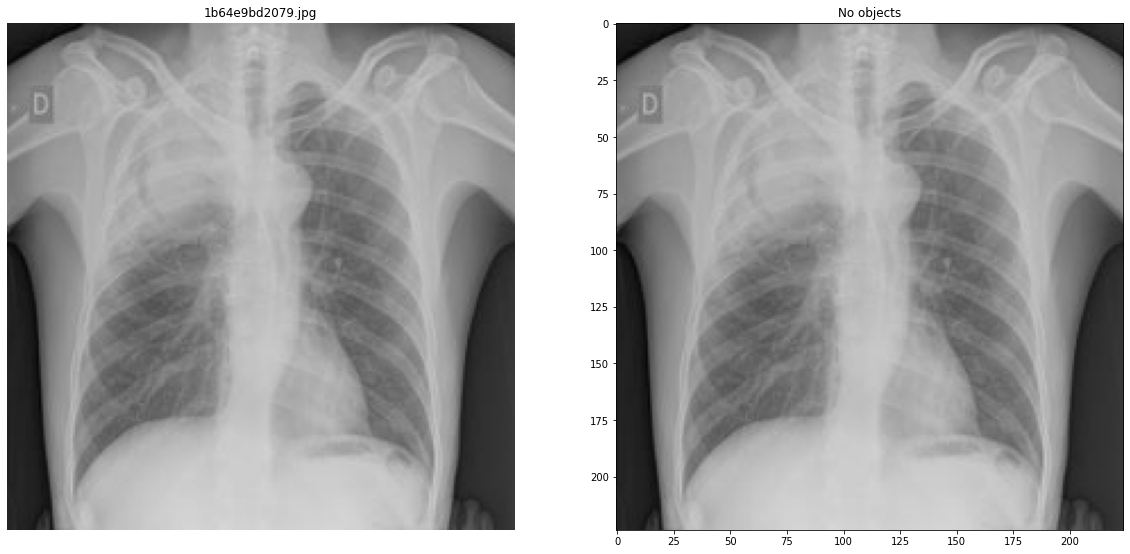

(224, 224, 3)


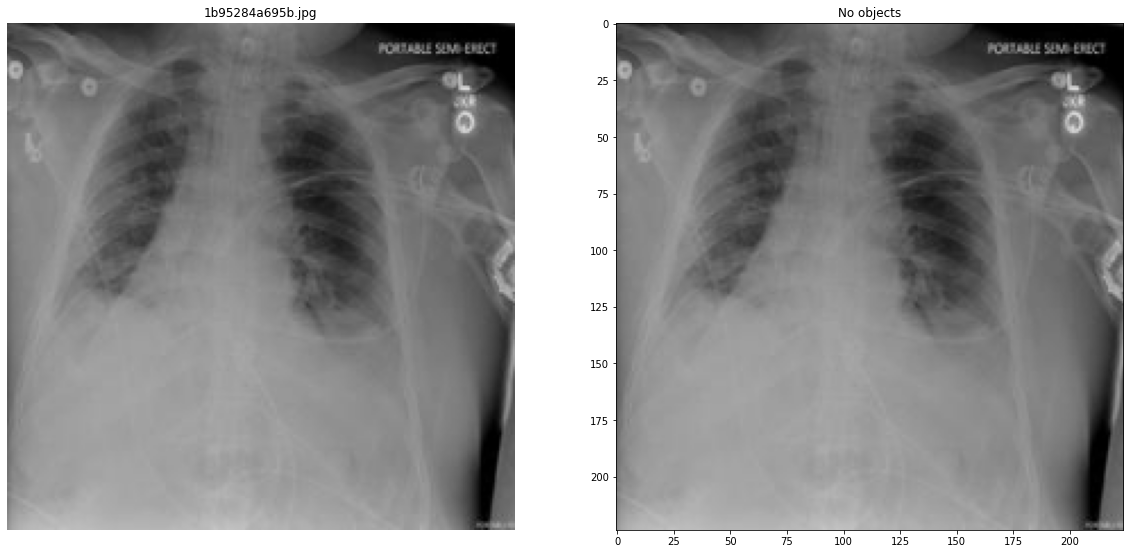

(224, 224, 3)


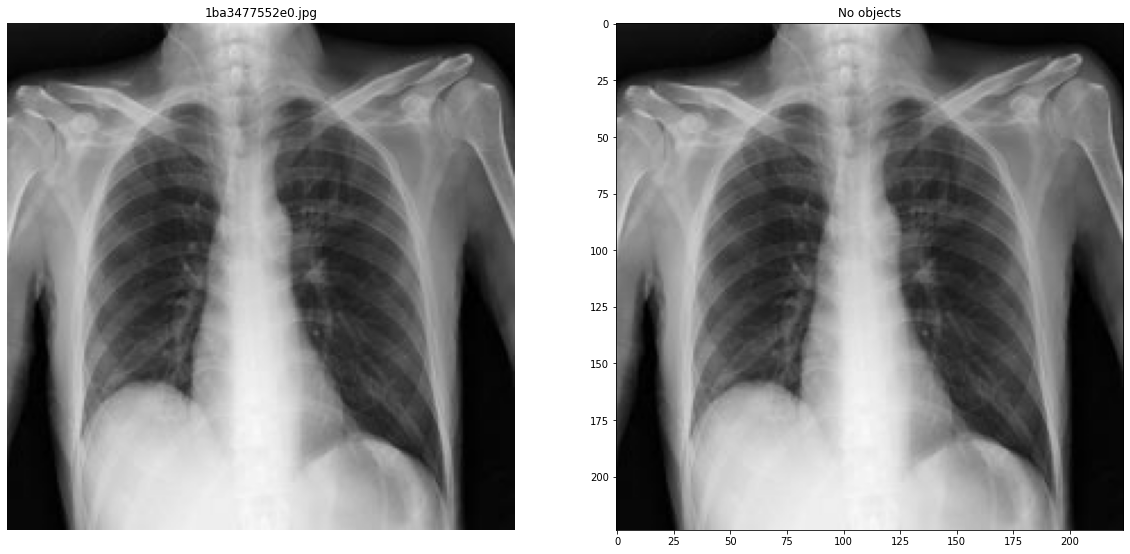

(224, 224, 3)


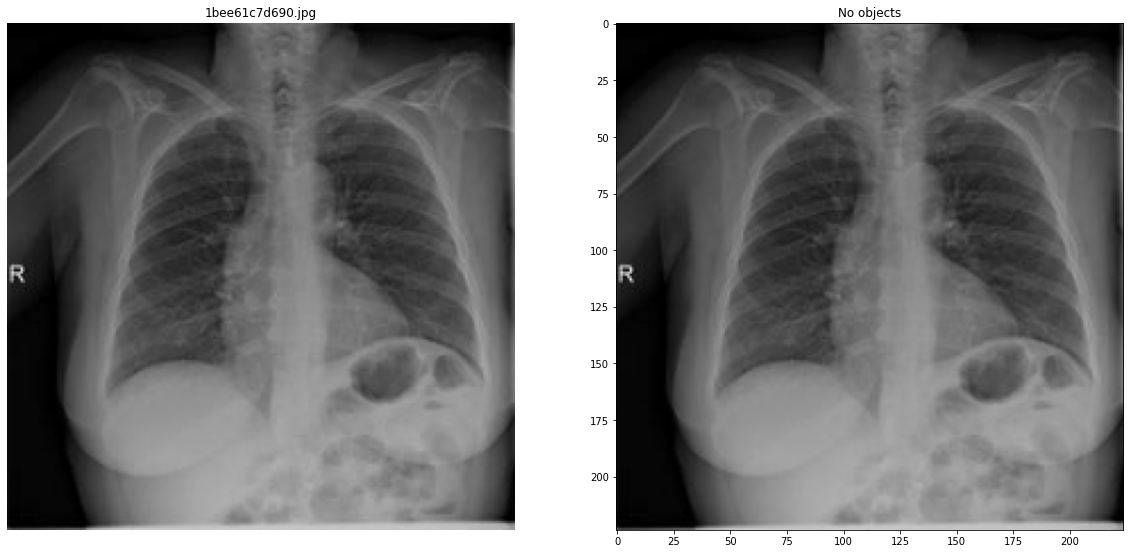

(224, 224, 3)


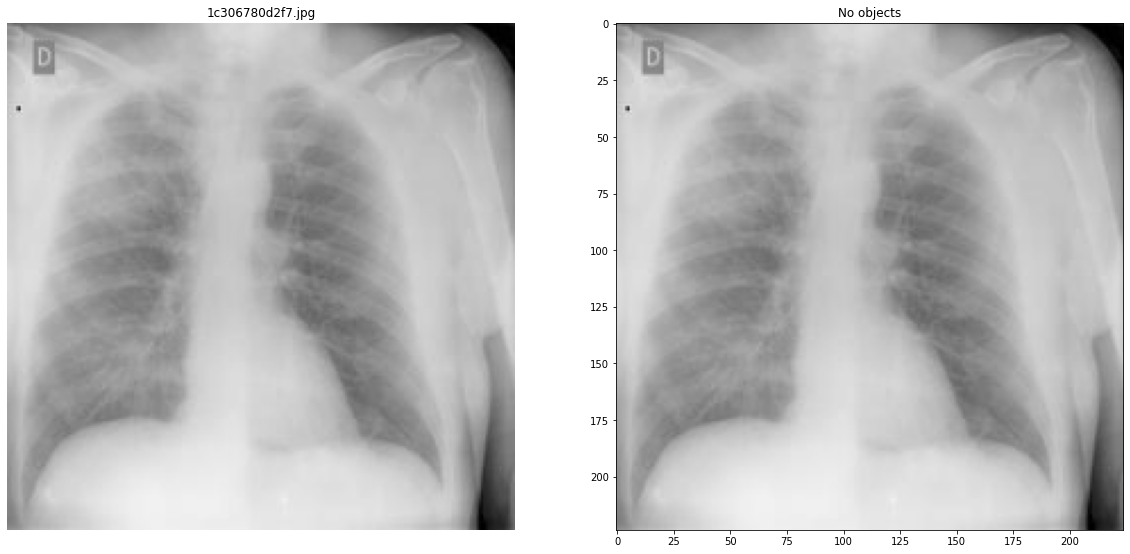

(224, 224, 3)


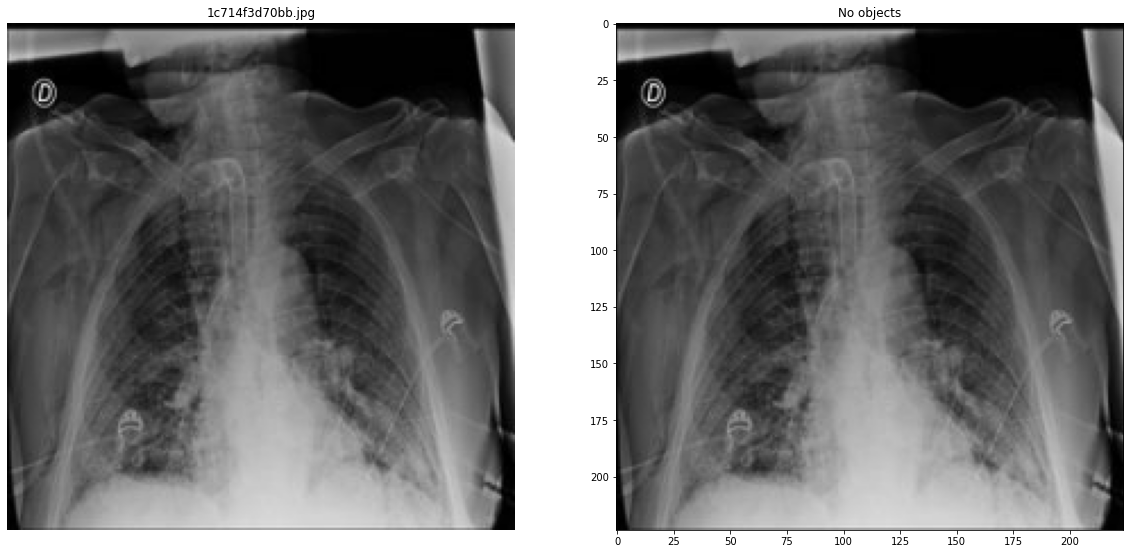

(224, 224, 3)


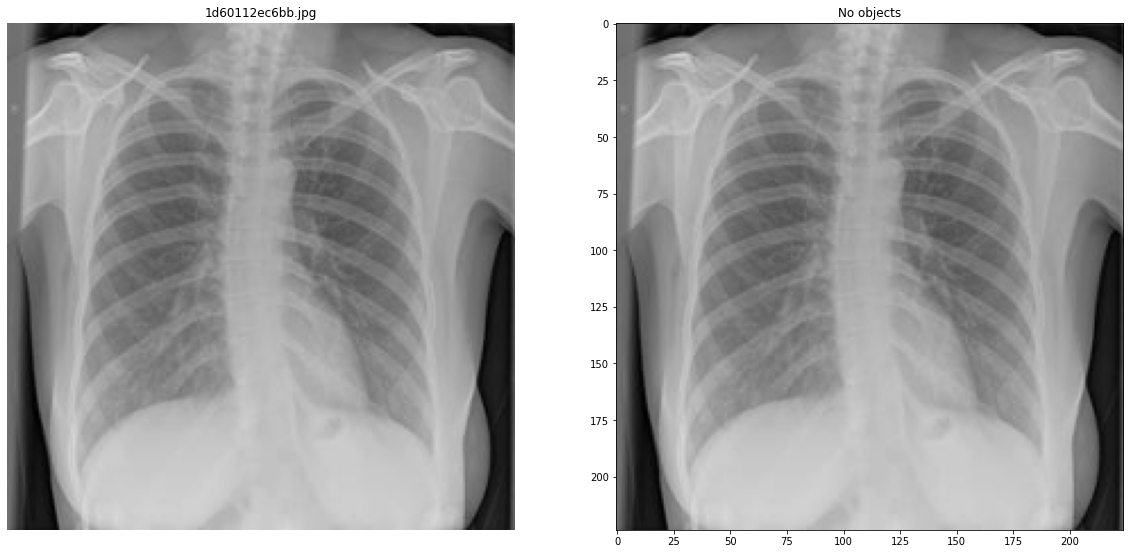

In [48]:
for i in range(50):
    test_predictions(test_ds[i][-1])